# CONFIG

In [58]:
# Need to be the same in strats_notebook.ipynb and clutering_STraTS_encoder.ipynb 
HYPER_PARAM = {'d_var':40, 'd_demo':10, 'N':2, 'he':4, 'dropout':0.2}
DATA_SET = 'bodo' # can be {'bodo', 'physionet'}
MIN_LENGTH_OF_STAY = 8
MAX_LENGTH_OF_STAY = 60
SAMPLES_TO_PREDICT = 1
WARD_TO_USE = 'WardALL'                             # alternatives {'Ward2','Ward3','WardALL','WardNO'}
STATIC_VARIS = ['Gender', 'StaticImputed', 'WardID', 'WardChange']          # alternatives ['Gender', 'StaticImputed', 'WardChange', 'Unconscious', 'WardID'  + in physionet 'weight', 'Age']
DROP_VAIRS = []
USE_DAY_MEAN = ''       # '', '_dayMean'  take mean of values for each day.
IMPUTE_GENDER = '_ImputeGender' # '_ImputeGender'  impute gender with random gender with same rate as data.
REMOVE_MISSING_GENDER = '' # '_noMissGender'  remove patient if gender is missing.


In [59]:
# Unique for this file:
import os 
N_CLUSTERS = 3
DIM_REDUCTION_TO = 3 # 3 or lower if using T-SNE
USE_TSNE = True
SKIP_ENCODING_IF_POSSIBLE = True

WEIGHTS_PATH = './weights/'
DATA_PATH = './data/'
WEIGHTS_NAME = f'weight_{DATA_SET}_O{MIN_LENGTH_OF_STAY}U{MAX_LENGTH_OF_STAY}_{WARD_TO_USE}_SV{STATIC_VARIS}_pred{SAMPLES_TO_PREDICT}{IMPUTE_GENDER}{REMOVE_MISSING_GENDER}{USE_DAY_MEAN}_d_var{HYPER_PARAM["d_var"]}demo{HYPER_PARAM["d_demo"]}.h5'
DATA_NAME = f'triplets_{DATA_SET}_O{MIN_LENGTH_OF_STAY}U{MAX_LENGTH_OF_STAY}_{WARD_TO_USE}{IMPUTE_GENDER}{REMOVE_MISSING_GENDER}{USE_DAY_MEAN}.pkl'

PATH_OUTPUT = './output/'
SAVE_OUTPUT_AS = f'{WEIGHTS_NAME[0:-3]}_{DATA_NAME[0:-4]}.pkl'

DATA_ORIGNIAL =  f'EWS_0122-0423_scrubbed_O{MIN_LENGTH_OF_STAY}U{MAX_LENGTH_OF_STAY}.csv'
# for plotting
# df_score_average = pd.read_excel('./data/df_score_average_short.xlsx').drop(['Unnamed: 0'], axis=1)
# df_score_average = pd.read_excel('./data/df_score_average.xlsx').drop(['Unnamed: 0'], axis=1)

if not os.path.exists(WEIGHTS_PATH+WEIGHTS_NAME):
    raise ValueError(f'Weight path does not exist. Path. {WEIGHTS_PATH+WEIGHTS_NAME}')
else:
    print(WEIGHTS_NAME)
    print(SAVE_OUTPUT_AS)

weight_bodo_O8U60_WardALL_SV['Gender', 'StaticImputed', 'WardID', 'WardChange']_pred1_ImputeGender_d_var40demo10.h5
weight_bodo_O8U60_WardALL_SV['Gender', 'StaticImputed', 'WardID', 'WardChange']_pred1_ImputeGender_d_var40demo10_triplets_bodo_O8U60_WardALL_ImputeGender.pkl


In [60]:
from tensorflow.config.experimental import list_physical_devices
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Embedding, Activation, Dropout, Softmax, Layer, InputSpec, Input, Dense, Lambda, TimeDistributed, Concatenate, Add
from tensorflow.keras import initializers, regularizers, constraints, Model
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.ops import array_ops
from tensorflow import nn
from tensorflow.keras.optimizers import Adam
# making tf_utils.smart_cond work with latest version of tensorflow 2.xx

from tensorflow.python.framework import smart_cond as smart_module
from tensorflow.python.ops import control_flow_ops, variables

def smart_cond(pred, true_fn=None, false_fn=None, name=None):
  if isinstance(pred, variables.Variable):
    return control_flow_ops.cond(
        pred, true_fn=true_fn, false_fn=false_fn, name=name)
  return smart_module.smart_cond(
      pred, true_fn=true_fn, false_fn=false_fn, name=name)

import pandas as pd
from sklearn.decomposition import PCA

import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()
# check for GPU
print("Num GPUs Available: ", len(list_physical_devices('GPU')))


Num GPUs Available:  0


# Configuration

## Define model architecture.

In [61]:
def forecast_loss(y_true, y_pred):
    return K.sum(y_true[:,V:]*(y_true[:,:V]-y_pred)**2, axis=-1)

    
class CVE(Layer):
    def __init__(self, hid_units, output_dim):
        self.hid_units = hid_units
        self.output_dim = output_dim
        super(CVE, self).__init__()
        
    def build(self, input_shape): 
        self.W1 = self.add_weight(name='CVE_W1',
                            shape=(1, self.hid_units),
                            initializer='glorot_uniform',
                            trainable=True)
        self.b1 = self.add_weight(name='CVE_b1',
                            shape=(self.hid_units,),
                            initializer='zeros',
                            trainable=True)
        self.W2 = self.add_weight(name='CVE_W2',
                            shape=(self.hid_units, self.output_dim),
                            initializer='glorot_uniform',
                            trainable=True)
        super(CVE, self).build(input_shape)
        
    def call(self, x):
        x = K.expand_dims(x, axis=-1)
        x = K.dot(K.tanh(K.bias_add(K.dot(x, self.W1), self.b1)), self.W2)
        return x
        
    def compute_output_shape(self, input_shape):
        return input_shape + (self.output_dim,)
    
    
class Attention(Layer):
    
    def __init__(self, hid_dim):
        self.hid_dim = hid_dim
        super(Attention, self).__init__()

    def build(self, input_shape):
        d = input_shape.as_list()[-1]
        self.W = self.add_weight(shape=(d, self.hid_dim), name='Att_W',
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.hid_dim,), name='Att_b',
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(shape=(self.hid_dim,1), name='Att_u',
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(Attention, self).build(input_shape)
        
    def call(self, x, mask, mask_value=-1e30):
        attn_weights = K.dot(K.tanh(K.bias_add(K.dot(x,self.W), self.b)), self.u)
        mask = K.expand_dims(mask, axis=-1)
        attn_weights = mask*attn_weights + (1-mask)*mask_value
        attn_weights = K.softmax(attn_weights, axis=-2)
        return attn_weights
        
    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (1,)
    
    
class Transformer(Layer):
    
    def __init__(self, N=2, h=8, dk=None, dv=None, dff=None, dropout=0):
        self.N, self.h, self.dk, self.dv, self.dff, self.dropout = N, h, dk, dv, dff, dropout
        self.epsilon = K.epsilon() * K.epsilon()
        super(Transformer, self).__init__()

    def build(self, input_shape):
        d = input_shape.as_list()[-1]
        if self.dk==None:
            self.dk = d//self.h
        if self.dv==None:
            self.dv = d//self.h
        if self.dff==None:
            self.dff = 2*d
        self.Wq = self.add_weight(shape=(self.N, self.h, d, self.dk), name='Wq',
                                 initializer='glorot_uniform', trainable=True)
        self.Wk = self.add_weight(shape=(self.N, self.h, d, self.dk), name='Wk',
                                 initializer='glorot_uniform', trainable=True)
        self.Wv = self.add_weight(shape=(self.N, self.h, d, self.dv), name='Wv',
                                 initializer='glorot_uniform', trainable=True)
        self.Wo = self.add_weight(shape=(self.N, self.dv*self.h, d), name='Wo',
                                 initializer='glorot_uniform', trainable=True)
        self.W1 = self.add_weight(shape=(self.N, d, self.dff), name='W1',
                                 initializer='glorot_uniform', trainable=True)
        self.b1 = self.add_weight(shape=(self.N, self.dff), name='b1',
                                 initializer='zeros', trainable=True)
        self.W2 = self.add_weight(shape=(self.N, self.dff, d), name='W2',
                                 initializer='glorot_uniform', trainable=True)
        self.b2 = self.add_weight(shape=(self.N, d), name='b2',
                                 initializer='zeros', trainable=True)
        self.gamma = self.add_weight(shape=(2*self.N,), name='gamma',
                                 initializer='ones', trainable=True)
        self.beta = self.add_weight(shape=(2*self.N,), name='beta',
                                 initializer='zeros', trainable=True)
        super(Transformer, self).build(input_shape)
        
    def call(self, x, mask, mask_value=-1e-30):
        mask = K.expand_dims(mask, axis=-2)
        for i in range(self.N):
            # MHA
            mha_ops = []
            for j in range(self.h):
                q = K.dot(x, self.Wq[i,j,:,:])
                k = K.permute_dimensions(K.dot(x, self.Wk[i,j,:,:]), (0,2,1))
                v = K.dot(x, self.Wv[i,j,:,:])
                A = K.batch_dot(q,k)
                # Mask unobserved steps.
                A = mask*A + (1-mask)*mask_value
                # Mask for attention dropout.
                def dropped_A():
                    dp_mask = K.cast((K.random_uniform(shape=array_ops.shape(A))>=self.dropout), K.floatx())
                    return A*dp_mask + (1-dp_mask)*mask_value
                A = smart_cond(K.learning_phase(), dropped_A, lambda: array_ops.identity(A))
                A = K.softmax(A, axis=-1)
                mha_ops.append(K.batch_dot(A,v))
            conc = K.concatenate(mha_ops, axis=-1)
            proj = K.dot(conc, self.Wo[i,:,:])
            # Dropout.
            proj = smart_cond(K.learning_phase(), lambda: array_ops.identity(nn.dropout(proj, rate=self.dropout)),\
                                       lambda: array_ops.identity(proj))
            # Add & LN
            x = x+proj
            mean = K.mean(x, axis=-1, keepdims=True)
            variance = K.mean(K.square(x - mean), axis=-1, keepdims=True)
            std = K.sqrt(variance + self.epsilon)
            x = (x - mean) / std
            x = x*self.gamma[2*i] + self.beta[2*i]
            # FFN
            ffn_op = K.bias_add(K.dot(K.relu(K.bias_add(K.dot(x, self.W1[i,:,:]), self.b1[i,:])), 
                           self.W2[i,:,:]), self.b2[i,:,])
            # Dropout.
            ffn_op = smart_cond(K.learning_phase(), lambda: array_ops.identity(nn.dropout(ffn_op, rate=self.dropout)),\
                                       lambda: array_ops.identity(ffn_op))
            # Add & LN
            x = x+ffn_op
            mean = K.mean(x, axis=-1, keepdims=True)
            variance = K.mean(K.square(x - mean), axis=-1, keepdims=True)
            std = K.sqrt(variance + self.epsilon)
            x = (x - mean) / std
            x = x*self.gamma[2*i+1] + self.beta[2*i+1]            
        return x
        
    def compute_output_shape(self, input_shape):
        return input_shape


def build_strats(D, max_len, V, d, d_demo, N, he, dropout, forecast=False):
    demo = Input(shape=(D,))
    demo_enc = Dense(2*d_demo, activation='tanh')(demo)
    demo_enc = Dense(d_demo, activation='tanh')(demo_enc)

    varis = Input(shape=(max_len,))
    values = Input(shape=(max_len,))
    times = Input(shape=(max_len,))
    varis_emb = Embedding(V+1, d)(varis)
    cve_units = int(np.sqrt(d))
    values_emb = CVE(cve_units, d)(values)
    times_emb = CVE(cve_units, d)(times)
    comb_emb = Add()([varis_emb, values_emb, times_emb]) # b, L, d
    mask = Lambda(lambda x:K.clip(x,0,1))(varis) # b, L
    cont_emb = Transformer(N, he, dk=None, dv=None, dff=None, dropout=dropout)(comb_emb, mask=mask)
    attn_weights = Attention(2*d)(cont_emb, mask=mask)
    fused_emb = Lambda(lambda x:K.sum(x[0]*x[1], axis=-2))([cont_emb, attn_weights])
    conc = Concatenate(axis=-1)([fused_emb, demo_enc])
    fore_op = Dense(V)(conc)
    model = Model([demo, times, values, varis], conc)
    if forecast:
        fore_model = Model([demo, times, values, varis], fore_op)
        return [model, fore_model]
    return model


## Load data

In [62]:

# Read data.
if DATA_SET=='physionet':
    datapath = DATA_PATH+'physionet_2012_preprocessed_noNormalization.pkl'
    data, oc, train_ind, valid_ind, test_ind = pickle.load(open(DATA_PATH+'physionet_2012_preprocessed_noNormalization.pkl', 'rb'))

    static_varis = STATIC_VARIS # ['Age', 'Gender']


    # Fix age.
    data.loc[(data.variable=='Age')&(data.value>200), 'value'] = 91.4

    # Remove unwanted variables.
    data = data[~data['variable'].isin(DROP_VAIRS)]

    # Get static data with mean fill and missingness indicator.
    ii = data.variable.isin(static_varis)
    static_data = data.loc[ii]
    data = data.loc[~ii]
    def inv_list(l, start=0):
        d = {}
        for i in range(len(l)):
            d[l[i]] = i+start
        return d
    static_var_to_ind = inv_list(static_varis)
    D = len(static_varis)
    N = data.ts_ind.max()+1
    demo = np.zeros((N, D))
    for row in static_data.itertuples():
        demo[row.ts_ind, static_var_to_ind[row.variable]] = row.value

    # Normalize static data.
    means = demo.mean(axis=0, keepdims=True)
    stds = demo.std(axis=0, keepdims=True)
    stds = (stds==0)*1 + (stds!=0)*stds
    demo = (demo-means)/stds


    feat_dynamic = [
        'HR',           # [Heart rate (bpm)]
        'NIDiasABP',    # [Non-invasive diastolic arterial blood pressure (mmHg)]
        'NISysABP',     # [Non-invasive systolic arterial blood pressure (mmHg)]
        'PaO2',         # [Partial pressure of arterial O2 (mmHg)]
        'RespRate',     # [Respiration rate (bpm)]
        'SaO2',         # [O2 saturation in hemoglobin (%)]
        'Temp',         # [Temperature (°C)]
        # Features not in Bodo data below.
        'Albumin',      # (g/dL)
        'ALP',          # [Alkaline phosphatase (IU/L)]
        'ALT',          # [Alanine transaminase (IU/L)]
        'AST',          # [Aspartate transaminase (IU/L)]
        'Bilirubin',    # (mg/dL)
        'BUN',          # [Blood urea nitrogen (mg/dL)]
        'Cholesterol',  # (mg/dL)
        'Creatinine',   # [Serum creatinine (mg/dL)]
        'DiasABP',      # [Invasive diastolic arterial blood pressure (mmHg)]
        'FiO2',         # [Fractional inspired O2 (0-1)]
        'GCS',          # [Glasgow Coma Score (3-15)]
        'Glucose',      # [Serum glucose (mg/dL)]
        'HCO3',         # [Serum bicarbonate (mmol/L)]
        'HCT',          # [Hematocrit (%)]
        'K',            # [Serum potassium (mEq/L)]
        'Lactate',      # (mmol/L)
        'Mg',           # [Serum magnesium (mmol/L)]
        'MAP',          # [Invasive mean arterial blood pressure (mmHg)]
        'MechVent',     # [Mechanical ventilation respiration (0:false, or 1:true)]
        'Na',           # [Serum sodium (mEq/L)]
        'NIMAP',        # [Non-invasive mean arterial blood pressure (mmHg)]
        'PaCO2',        # [partial pressure of arterial CO2 (mmHg)]
        'pH',           # [Arterial pH (0-14)]
        'Platelets',    # (cells/nL)
        'SysABP',       # [Invasive systolic arterial blood pressure (mmHg)]
        'TropI',        # [Troponin-I (μg/L)]
        'TropT',        # [Troponin-T (μg/L)]
        'Urine',        # [Urine output (mL)]
        'WBC'           # [White blood cell count (cells/nL)]
        ]

    data = data.loc[data.variable.isin(feat_dynamic)]

    # normalize with ideal values, Bodo features
    #opt_val = [['PatientID','WardID','Timestamp', 'Systolic', 'Diastolic', 'O2', 'Pulse', 'Temp', 'Rf', 'Gender', 'onO2',   'Unconscious', 'WardName']]
    opt_val = [     0,          0,          0,          120,        80,      96,    70,     37,     16,     0,        0,             0,       0   ]

    data.loc[data.variable == 'HR', 'value'] -= 70
    data.loc[data.variable == 'RespRate', 'value'] -= 16
    data.loc[data.variable == 'Temp', 'value'] -= 37
    data.loc[data.variable == 'SaO2', 'value'] -= 96
    data.loc[data.variable == 'NIDiasABP', 'value'] -= 80
    data.loc[data.variable == 'NISysABP', 'value'] -= 120

    # Add columns to the data: checkup, number of checkups on the patient at the given row
    patient_ids = data.ts_ind.unique()
    data_grouped = data.groupby('ts_ind')
    def generate_checkups(patient_data):
        reps = patient_data['hour'].value_counts(sort=False)
        checkups = np.repeat(np.arange(len(reps)), reps)
        return pd.DataFrame({'checkup': checkups})

    df_checkup = data_grouped.apply(generate_checkups).reset_index(level=1, drop=True).reset_index()
    data['checkup'] = df_checkup['checkup'].values


    # Add columns to the data: PatientID, same as ts_ind for Physionet
    data['PatientID'] = data['ts_ind']
    data = data[['ts_ind', 'PatientID', 'checkup', 'hour', 'variable', 'value', 'mean', 'std']]

    # Drop patients with less than MIN_LENGTH_OF_STAY different times with datasamples
    droppedID = data[data_grouped['checkup'].transform('max') <= MIN_LENGTH_OF_STAY]['ts_ind'].unique()
    data = data[~data['ts_ind'].isin(droppedID)]
    print(f'Dropped {len(droppedID)} patients with less then MIN_LENGTH_OF_STAY:{MIN_LENGTH_OF_STAY} samples.')

    max_hour = int(data.hour.max())
    obs_windows = range(MIN_LENGTH_OF_STAY-10, MAX_LENGTH_OF_STAY, 10)

    

elif DATA_SET=='bodo':
    data, oc, train_ind, valid_ind, test_ind = pickle.load(open(DATA_PATH+DATA_NAME, 'rb'))
    static_varis = STATIC_VARIS # ['Gender', 'WardID']

    # Remove unwanted variables.
    data = data[~data['variable'].isin(DROP_VAIRS)]

    # Get static data with mean fill and missingness indicator.
    ii = data.variable.isin(static_varis)
    static_data = data.loc[ii]
    data = data.loc[~ii]
    def inv_list(l, start=0):
        d = {}
        for i in range(len(l)):
            d[l[i]] = i+start
        return d
    static_var_to_ind = inv_list(static_varis)
    D = len(static_varis)
    N = data.ts_ind.max()+1
    demo = np.zeros((N, D))
    for row in static_data.itertuples():
        demo[row.ts_ind, static_var_to_ind[row.variable]] = row.value

    # Normalize static data.
    means = demo.mean(axis=0, keepdims=True)
    stds = demo.std(axis=0, keepdims=True)
    stds = (stds==0)*1 + (stds!=0)*stds
    demo = (demo-means)/stds



print(f'{len(data.PatientID.unique())} patients in data set.')
data_orig = data
data

7822 patients in data set.


ts_ind  PatientID checkup       hour     variable     value  \
10           0     279660       0   0.000000     Systolic  1.048898   
11           0     279660       1   7.389722     Systolic    0.6953   
12           0     279660       2  15.353333     Systolic -0.144495   
13           0     279660       3  21.750556     Systolic  1.667695   
14           0     279660       4  32.708611     Systolic  0.341702   
...        ...        ...     ...        ...          ...       ...   
1503778   7821  311815932       4  20.266111  Unconscious         0   
1503779   7821  311815932       5  26.727500  Unconscious         0   
1503780   7821  311815932       6  32.344167  Unconscious         0   
1503781   7821  311815932       7  37.047222  Unconscious         0   
1503782   7821  311815932       8  40.289444  Unconscious         0   

              mean        std     Timestamp  
10       11.269137  22.624557  1.657193e+12  
11       11.269137  22.624557  1.657220e+12  
12       11.269137  22.624557  1.657248e+12  
13       11.269137  22.624557  1.657271e+12  
14       11.269137  22.624557  1.657311e+12  
...            ...        ...           ...  
1503778          0          1  1.659661e+12  
1503779          0          1  1.659684e+12  
1503780          0          1  1.659705e+12  
1503781          0          1  1.659722e+12  
1503782          0          1  1.659733e+12  

[1041093 rows x 9 columns]

In [63]:
print(static_data.variable.unique())
print(data_orig.variable.unique())

['WardID' 'Gender' 'StaticImputed' 'WardChange']
['Systolic' 'Diastolic' 'O2' 'Pulse' 'Temp' 'Rf' 'onO2' 'EwsScore'
 'Unconscious']


## Preprocess data

In [64]:
def pad(x):
    return x+[0]*(fore_max_len-len(x))

# Find max_len.
# fore_max_len = 880 # original
fore_max_len = MAX_LENGTH_OF_STAY # No need for longer than max amount of datapoints for each patient?

# Get variable indices.
PatientID_list = data.PatientID.unique()
varis = sorted(list(set(data.variable)))
V = len(varis)
var_to_ind = inv_list(varis, start=1)
data['vind'] = data.variable.map(var_to_ind)
data = data[['ts_ind', 'vind', 'hour', 'value']].sort_values(by=['ts_ind', 'vind', 'hour'])


data = data.groupby('ts_ind').head(fore_max_len)
data = data.groupby('ts_ind').agg({'vind':list, 'hour':list, 'value':list}).reset_index()

for col in ['vind', 'hour', 'value']:
    data[col] = data[col].apply(pad)

indexes = np.array(list(data.ts_ind))
times_ip = np.array(list(data.hour))
values_ip = np.array(list(data.value))
varis_ip = np.array(list(data.vind))

ts_ind_list = data.ts_ind.unique()
# del data

demo = demo[indexes]
# Get train and valid ts_ind for forecast task.
all_ind = np.concatenate((train_ind, valid_ind, test_ind))
data_sub = oc.loc[oc.ts_ind.isin(all_ind)].ts_ind.unique()
data_ind = oc.loc[oc.ts_ind.isin(data_sub)].ts_ind.unique() # Add remaining ts_ind s of train subjects.

# Generate inputs
data_ind = np.argwhere(np.in1d(indexes, all_ind)).flatten()
data_to_inference = [st_ind[data_ind] for st_ind in [demo, times_ip, values_ip, varis_ip]]
del times_ip, values_ip, varis_ip, demo




## Load model.

In [65]:
print('Does the path to weights exists?', os.path.exists(WEIGHTS_PATH+WEIGHTS_NAME))
print('Path:', WEIGHTS_PATH+WEIGHTS_NAME)

if DATA_SET == 'bodo':
    lr, batch_size, samples_per_epoch, patience = 0.0005, 32, 2048, 5

elif DATA_SET=='physionet':
    lr, batch_size, samples_per_epoch, patience = 0.0005, 32, 20480, 5
    
D = len(static_varis)
fore_max_len = MAX_LENGTH_OF_STAY

d_var = HYPER_PARAM['d_var']  
d_demo = HYPER_PARAM['d_demo'] 
N = HYPER_PARAM['N'] 
he = HYPER_PARAM['he']  
dropout = HYPER_PARAM['dropout'] 
print(f'D={D}, fore_max_len={fore_max_len}, V={V}, d_var={d_var}, d_demo={d_demo}, N={N}, he={he}, dropout={dropout}')

model_encoder, fore_model =  build_strats(D, fore_max_len, V, d_var, d_demo, N, he, dropout, forecast=True)
fore_model.compile(loss=forecast_loss, optimizer=Adam(lr))


model_encoder.load_weights(WEIGHTS_PATH+WEIGHTS_NAME, by_name=True, skip_mismatch=True)
print (model_encoder.summary())


Does the path to weights exists? True
Path: ./weights/weight_bodo_O8U60_WardALL_SV['Gender', 'StaticImputed', 'WardID', 'WardChange']_pred1_ImputeGender_d_var40demo10.h5
D=4, fore_max_len=60, V=9, d_var=40, d_demo=10, N=2, he=4, dropout=0.2
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 60)]                 0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 60)]                 0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 60)]                 0         []                            
                                                 

### Encode input

In [66]:
i = 0
# check if the encoding has been saved before.
if SKIP_ENCODING_IF_POSSIBLE and os.path.exists(PATH_OUTPUT+SAVE_OUTPUT_AS):
    df_out =  pickle.load(open(PATH_OUTPUT+SAVE_OUTPUT_AS, 'rb'))
else:
    model_encoder.load_weights(WEIGHTS_PATH+WEIGHTS_NAME, by_name=True, skip_mismatch=True)
    output = []
    demo_out_list = []
    # for ind in tqdm(ts_ind_list):
    #     output.append(model_encoder([input[[ind]] for input in data_to_inference]))
    inference_model = Model(inputs=model_encoder.input, outputs=model_encoder.get_layer('dense_1').output)  # Replace 'dense_2' with the actual layer name

    for ind in tqdm(range(0,len(ts_ind_list))):
        inputs = []
        for data in data_to_inference:
            inputs.append(data[[ind]])

        output.append(model_encoder(inputs))
        
        if i<=10:
            i+=1
            demo_enc_output = inference_model.predict(inputs)
            demo_out_list.append(demo_enc_output)
            # print(f'demo_enc_output shape:\n{np.shape(demo_enc_output)}')
            # print(f'demo_enc_output:\n{demo_enc_output}')
        else:
            1
            # break
    
    # sort the output to a dataframe
    df_out = np.array(output).squeeze(axis=1)
    df_out = pd.DataFrame(df_out)
    df_out.insert(0, 'PatientID', PatientID_list)
    # df_out.dropna(inplace=True) # remove rows with NaN values
    # df_out = df_out.loc[:, (df_out != 0).any()] # remove columns with only 0 values

df_out


PatientID         0         1         2         3         4         5  \
0        279660 -0.036815 -0.147792  0.526586  0.695731 -0.929571 -0.677457   
1        402812  0.315167  0.336100  0.176019  0.412385 -0.872709 -0.255437   
2        502271  0.195679 -0.587091  0.957517  0.098259 -1.316922 -0.727019   
3        637860  0.245699 -0.542331  1.138412  0.168223 -1.181689 -0.425471   
4        660535  0.124991 -0.682386  1.186408  0.373261 -1.264008 -0.742563   
...         ...       ...       ...       ...       ...       ...       ...   
7817  221585990  0.285816 -0.505285  0.973969  0.440484 -1.494370 -0.894215   
7818  271815932  0.078723 -0.521433  1.140910  0.585072 -1.181207 -0.715989   
7819  291815932 -0.025565 -0.303065  1.070700  0.862033 -1.096530 -0.787891   
7820  301815932 -0.041125 -0.448027  1.162628  0.754857 -1.134645 -0.792198   
7821  311815932 -0.207815 -0.583503  1.466768  0.332452 -0.921398 -0.723106   

             6         7         8  ...        40        41        42  \
0    -1.036351 -0.075293 -0.571331  ...  0.198087 -0.396611 -0.339580   
1    -1.202238 -0.325381 -0.095462  ... -0.615482  0.197301  0.205332   
2    -0.693689 -0.303428  0.040323  ...  0.981166 -0.809104 -0.577969   
3    -0.575405  0.098515 -0.713888  ...  0.675476 -0.096849 -0.149518   
4    -0.771220 -0.153386 -0.656080  ...  0.982689 -0.751761 -0.646009   
...        ...       ...       ...  ...       ...       ...       ...   
7817 -0.992531  0.147401 -0.708613  ... -0.966225  0.733462  0.692665   
7818 -0.830413  0.432849 -0.902201  ...  0.675476 -0.096849 -0.149518   
7819 -0.768976  0.371004 -0.873338  ...  0.675476 -0.096849 -0.149518   
7820 -1.026483  0.390593 -0.964788  ...  0.675476 -0.096849 -0.149518   
7821 -1.456666  0.382808 -0.955059  ...  0.675476 -0.096849 -0.149518   

            43        44        45        46        47        48        49  
0     0.136491 -0.059962  0.496556  0.340171 -0.786333  0.426463  0.699622  
1    -0.283419  0.007223 -0.041475  0.042289  0.308558  0.229957  0.076089  
2     0.851671  0.034087 -0.071082  0.020530 -0.765778  0.516065 -0.411566  
3     0.517392  0.062893  0.124680 -0.163285 -0.134760  0.385427 -0.400280  
4     0.939547  0.329297  0.211359 -0.459022 -0.774822  0.373301 -0.357129  
...        ...       ...       ...       ...       ...       ...       ...  
7817 -0.797584 -0.082987 -0.182993  0.131550  0.865644 -0.271512  0.350624  
7818  0.517392  0.062893  0.124680 -0.163285 -0.134760  0.385427 -0.400280  
7819  0.517392  0.062893  0.124680 -0.163285 -0.134760  0.385427 -0.400280  
7820  0.517392  0.062893  0.124680 -0.163285 -0.134760  0.385427 -0.400280  
7821  0.517392  0.062893  0.124680 -0.163285 -0.134760  0.385427 -0.400280  

[7822 rows x 51 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


array([-1.50226899, -1.04124892, -0.69064114, -0.56918143, -0.41849735,
        0.12098671,  0.96038515,  1.74424242,  1.75690904,  2.10539339,
        2.55587027,  4.17912597,  4.62928414,  4.99075383,  9.67706563])

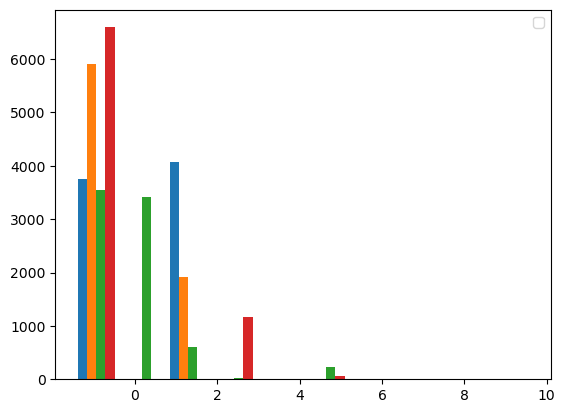

In [67]:

plt.hist(data_to_inference[0])
plt.legend()
np.unique(data_to_inference[0])
# len(np.unique(demo_out_list))

# Save output

In [68]:
# Save data.
if os.path.exists(PATH_OUTPUT):
    print('Saving encoded data as:', PATH_OUTPUT+SAVE_OUTPUT_AS)
    pickle.dump(df_out, open(PATH_OUTPUT+SAVE_OUTPUT_AS,'wb'))
else:
    print('Can NOT save file, path does not exist, PATH_DATA:', PATH_OUTPUT)
# df_ts_id_PatientID.to_excel('../data/bodo_ts_id_to_PatientID.xlsx')
df_out

Saving encoded data as: ./output/weight_bodo_O8U60_WardALL_SV['Gender', 'StaticImputed', 'WardID', 'WardChange']_pred1_ImputeGender_d_var40demo10_triplets_bodo_O8U60_WardALL_ImputeGender.pkl


PatientID         0         1         2         3         4         5  \
0        279660 -0.036815 -0.147792  0.526586  0.695731 -0.929571 -0.677457   
1        402812  0.315167  0.336100  0.176019  0.412385 -0.872709 -0.255437   
2        502271  0.195679 -0.587091  0.957517  0.098259 -1.316922 -0.727019   
3        637860  0.245699 -0.542331  1.138412  0.168223 -1.181689 -0.425471   
4        660535  0.124991 -0.682386  1.186408  0.373261 -1.264008 -0.742563   
...         ...       ...       ...       ...       ...       ...       ...   
7817  221585990  0.285816 -0.505285  0.973969  0.440484 -1.494370 -0.894215   
7818  271815932  0.078723 -0.521433  1.140910  0.585072 -1.181207 -0.715989   
7819  291815932 -0.025565 -0.303065  1.070700  0.862033 -1.096530 -0.787891   
7820  301815932 -0.041125 -0.448027  1.162628  0.754857 -1.134645 -0.792198   
7821  311815932 -0.207815 -0.583503  1.466768  0.332452 -0.921398 -0.723106   

             6         7         8  ...        40        41        42  \
0    -1.036351 -0.075293 -0.571331  ...  0.198087 -0.396611 -0.339580   
1    -1.202238 -0.325381 -0.095462  ... -0.615482  0.197301  0.205332   
2    -0.693689 -0.303428  0.040323  ...  0.981166 -0.809104 -0.577969   
3    -0.575405  0.098515 -0.713888  ...  0.675476 -0.096849 -0.149518   
4    -0.771220 -0.153386 -0.656080  ...  0.982689 -0.751761 -0.646009   
...        ...       ...       ...  ...       ...       ...       ...   
7817 -0.992531  0.147401 -0.708613  ... -0.966225  0.733462  0.692665   
7818 -0.830413  0.432849 -0.902201  ...  0.675476 -0.096849 -0.149518   
7819 -0.768976  0.371004 -0.873338  ...  0.675476 -0.096849 -0.149518   
7820 -1.026483  0.390593 -0.964788  ...  0.675476 -0.096849 -0.149518   
7821 -1.456666  0.382808 -0.955059  ...  0.675476 -0.096849 -0.149518   

            43        44        45        46        47        48        49  
0     0.136491 -0.059962  0.496556  0.340171 -0.786333  0.426463  0.699622  
1    -0.283419  0.007223 -0.041475  0.042289  0.308558  0.229957  0.076089  
2     0.851671  0.034087 -0.071082  0.020530 -0.765778  0.516065 -0.411566  
3     0.517392  0.062893  0.124680 -0.163285 -0.134760  0.385427 -0.400280  
4     0.939547  0.329297  0.211359 -0.459022 -0.774822  0.373301 -0.357129  
...        ...       ...       ...       ...       ...       ...       ...  
7817 -0.797584 -0.082987 -0.182993  0.131550  0.865644 -0.271512  0.350624  
7818  0.517392  0.062893  0.124680 -0.163285 -0.134760  0.385427 -0.400280  
7819  0.517392  0.062893  0.124680 -0.163285 -0.134760  0.385427 -0.400280  
7820  0.517392  0.062893  0.124680 -0.163285 -0.134760  0.385427 -0.400280  
7821  0.517392  0.062893  0.124680 -0.163285 -0.134760  0.385427 -0.400280  

[7822 rows x 51 columns]

## Get DataFrames, Original, Encoded and PCA on output

In [69]:
df_orig = pd.read_csv(DATA_PATH+DATA_ORIGNIAL)

df_orig['onO2'] = 0
df_orig.loc[df_orig.AirOrO2 == 'Oksygen', 'onO2'] = 1
del df_orig["AirOrO2"] 

df_orig['Unconscious'] = 0
df_orig.loc[df_orig.Consciousness != 'Våken', 'Unconscious'] = 1
del df_orig["Consciousness"] 

del df_orig['Index']
df_orig = df_orig.reindex(columns=[
'PatientID','WardID','Timestamp','Systolic','Diastolic','O2','Pulse','Temp','Rf','Gender','onO2','EwsScore','EwsType','Unconscious', 'EwsScore'])
df_orig.loc[df_orig.Gender == 'M', 'Gender'] = 1
df_orig.loc[df_orig.Gender == 'F', 'Gender'] = 0
df_orig.loc[df_orig.Gender == 'U', 'Gender'] = -1
df_orig.loc[df_orig.Gender == 'None', 'Gender'] = -1


# Use all wards or only a single WardID  # alternatives {'Ward2','Ward3','WardALL','WardNO'}
if WARD_TO_USE == 'ALLWard':
    pass
elif WARD_TO_USE == 'Ward2':
    df_orig = df_orig[df_orig.WardID == 2]
elif WARD_TO_USE == 'Ward3':
    df_orig = df_orig[df_orig.WardID == 3]
elif WARD_TO_USE == 'WardNO':
    df_orig = df_orig.drop('WardID', axis=1)

# normalize for optimal value
    #opt_val = [['PatientID','WardID','Timestamp', 'Systolic', 'Diastolic', 'O2', 'Pulse', 'Temp', 'Rf', 'Gender', 'onO2',   'Unconscious', 'EwsScore']]
if WARD_TO_USE == 'WardNO':
    opt_val = [     0,                      0,          120,        80,      96,    70,     37,     16,     0,        0,             0,       0]
else:
    opt_val = [     0,          0,          0,          120,        80,      96,    70,     37,     16,     0,        0,             0,       0]
df_orig

df_optDist = df_orig.iloc[:,:-2] - opt_val
df_optDist['Unconscious'] = df_orig['Unconscious']
# df_optDist['WardName'] = df_orig['WardName']
df_orig = df_optDist



df_orig.sort_values(by=['PatientID','Timestamp'], inplace=True,
               ascending = [True,True])
# df.index = range(1,len(df)+1)
if WARD_TO_USE == 'WardNO':    df_orig = df_orig[['PatientID','Timestamp', 'Systolic', 'Diastolic', 'O2', 'Pulse', 'Temp', 'Rf', 'Gender','onO2' ,'Unconscious', 'EwsScore']]
else:    df_orig = df_orig[['PatientID','Timestamp','WardID', 'Systolic', 'Diastolic', 'O2', 'Pulse', 'Temp', 'Rf', 'Gender','onO2' ,'Unconscious', 'EwsScore']]
df_orig_ohehot = pd.get_dummies(df_orig, prefix='Unconscious')


if USE_DAY_MEAN == '_dayMean':
    df_orig_dayMean = df_orig.copy()
    df_orig_dayMean['Day'] = pd.to_datetime(df_orig_dayMean.Timestamp, unit='ms')
    df_orig_dayMean.Day = df_orig_dayMean.Day.dt.date
    df_orig_dayMean.Gender = df_orig_dayMean.Gender.fillna(-1)
    df_orig_dayMean = df_orig_dayMean.groupby(['PatientID','Day']).mean()

    df_orig_dayMean = df_orig_dayMean.reset_index()
    pat_count = df_orig_dayMean.PatientID.value_counts()
    single_day = pat_count[pat_count<=3].index.tolist()
    df_orig_dayMean = df_orig_dayMean[~df_orig_dayMean.PatientID.isin(single_day)]
    df_orig_dayMean = df_orig_dayMean[['PatientID', 'Timestamp', 'Day', 'WardID', 'Systolic', 'Diastolic', 'O2', 'Pulse', 'Temp', 'Rf', 'Gender', 'onO2', 'Unconscious', 'EwsScore', 'StaticImputed']]

# df_orig = df_orig[['WardID', 'Systolic', 'Diastolic', 'O2', 'Pulse', 'Temp', 'Rf','onO2', 'Unconscious']]
print(f'{len(df_orig.PatientID.unique())} patients in dataset')
df_orig

7822 patients in dataset


C:\Users\burma\AppData\Local\Temp\ipykernel_26968\444444899.py:50: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_orig_ohehot = pd.get_dummies(df_orig, prefix='Unconscious')


PatientID      Timestamp  WardID  Systolic  Diastolic   O2  Pulse  \
52991     279660  1657193109000       8      35.0      -26.0  1.0   15.0   
53084     279660  1657219712000       8      27.0       -5.0 -3.0   23.0   
52601     279660  1657248381000       8       8.0      -14.0 -4.0    6.0   
52705     279660  1657271411000       8      49.0        9.0 -5.0   14.0   
52857     279660  1657310860000       2      19.0        3.0 -3.0   17.0   
...          ...            ...     ...       ...        ...  ...    ...   
98546  311815932  1659661219000       3       0.0      -26.0  4.0   19.0   
98580  311815932  1659684480000       3     -10.0      -13.0  1.0   29.0   
98593  311815932  1659704700000       3     -17.0      -17.0  0.0   23.0   
98610  311815932  1659721631000       3     -12.0      -13.0  4.0   22.0   
98630  311815932  1659733303000       3     -10.0      -17.0 -2.0   35.0   

       Temp   Rf Gender  onO2  Unconscious  EwsScore  
52991  -0.1  6.0      0     0            0         2  
53084  -0.5  4.0      0     0            0         1  
52601  -0.4  2.0      0     1            0         2  
52705   0.0  6.0      0     0            0         2  
52857  -0.9  2.0      0     0            0         0  
...     ...  ...    ...   ...          ...       ...  
98546  -0.8  6.0      0     0            0         2  
98580   2.3  1.0      0     0            0         4  
98593   1.8  4.0      0     0            0         3  
98610   2.5 -2.0      0     0            0         4  
98630  -1.1  4.0      0     0            0         4  

[115677 rows x 13 columns]

### Encoded data

In [70]:
df_encoded = df_out.copy()
df_encoded.columns = df_encoded.columns.astype(str)
df_encoded = df_encoded.drop('PatientID', axis=1)
# df_norm = preprocessing.normalize(df_encoded)
df_encoded.shape

(7822, 50)

### PCA

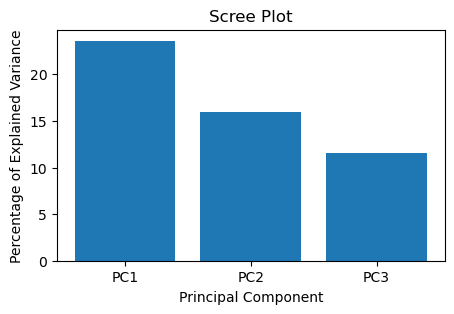

In [71]:
def PCA_df(df, n_components=DIM_REDUCTION_TO, plot=False):
    pca = PCA(n_components=n_components) # create a PCA object
    df_pca_val = df.values
    pca.fit(df_pca_val)
    pca_data = pca.transform(df_pca_val)

    per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
    cols = ['PC' + str(x) for x in range(1, len(per_var)+1)]

    df_pca = pd.DataFrame(pca_data, columns=cols)
    if plot:
        plt.figure(figsize=(5,3)) 
        plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=cols)
        plt.ylabel('Percentage of Explained Variance')
        plt.xlabel('Principal Component')
        plt.title('Scree Plot')
        plt.show()  


    return df_pca

df_pca = PCA_df(df_encoded, n_components=DIM_REDUCTION_TO, plot=True)

## Cluster methods

In [72]:
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
import seaborn as sns
from sklearn.datasets._samples_generator import make_blobs
from sklearn.utils.extmath import row_norms
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from hdbscan import HDBSCAN


# K-means
def KMeans_plot(df, df_plot=None, n_clusters = 2, random_state = None, n_init='auto', plot=False, pc=[0,1]):
    kmeans = KMeans(n_clusters = n_clusters, random_state = random_state, n_init=n_init)
    kmeans.fit(df)
    clusters = [label for label in kmeans.labels_]
    score = silhouette_score(df, clusters, metric='euclidean')
    if plot:
        try:
            if df_plot == None:
                df_plot=df.copy()
        except:
            df_plot=df_plot.copy()
        df_plot['cluster'] = clusters
        plt.figure(figsize=(15, 6))
        scatter_plot = sns.scatterplot(data = df_plot, x=df_plot.columns[pc[0]], y=df_plot.columns[pc[1]], hue='cluster', alpha=0.5, palette='Set1')
        plt.setp(scatter_plot.get_legend().get_title(), fontsize='20')
        plt.setp(scatter_plot.get_legend().get_texts(), fontsize='16')
        plt.title('K-Means Clustering', fontsize=24)
    return clusters, score

 

# Spectral Clustering
def SpectralClustering_plot(df, df_plot=None, n_clusters=2,  affinity='nearest_neighbors', n_init=100, assign_labels='kmeans', plot=False, pc=[0,1]):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    sc = SpectralClustering(n_clusters=n_clusters, affinity=affinity, n_init=n_init, assign_labels=assign_labels)
    clusters = sc.fit_predict(df_scaled)
    score = silhouette_score(df, clusters, metric='euclidean')
    if plot:
        try:
            if df_plot == None:
                df_plot=df.copy()
        except:
            df_plot=df_plot.copy()
        df_plot['cluster'] = clusters
        plt.figure(figsize=(15, 6))
        scatter_plot = sns.scatterplot(data = df_plot, x=df_plot.columns[pc[0]], y=df_plot.columns[pc[1]], hue='cluster', alpha=0.5, palette='Set1')
        plt.setp(scatter_plot.get_legend().get_title(), fontsize='20')
        plt.setp(scatter_plot.get_legend().get_texts(), fontsize='16')
        plt.title('Spectral Clustering', fontsize=24)
    return clusters, score



# Gaussian Mixture Model
def GausianMixtureModel_plot(df, df_plot=None, n_clusters=4, covariance_type='full', seed=42, plot=False, pc=[0,1]):
    X = df.to_numpy()
    # x_squared_norms = row_norms(X, squared=True)
    methods = ["kmeans", "random_from_data", "k-means++", "random"]
    if plot:
        try:
            if df_plot == None:
                df_plot=df.copy()
        except:
            df_plot=df_plot.copy()
        plt.figure(figsize=(4*len(methods), 2*len(methods)))
        plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.15, wspace=0.05, left=0.05, right=0.95)

    clusters_list = []
    score_list = []
    for n, method in enumerate(methods):
        random_state = np.random.RandomState(seed=seed)
        init = GaussianMixture(n_components=n_clusters, init_params=method, tol=1e-9, max_iter=0, random_state=random_state).fit(X).means_
        gmm = GaussianMixture(n_components=n_clusters, covariance_type=covariance_type, means_init=init, tol=1e-9, max_iter=2000, random_state=random_state).fit(X)

        clusters = gmm.predict(X)
        try:
            score = silhouette_score(df, clusters, metric='euclidean')    
        except:
            score = -42

        clusters_list.append(clusters)
        score_list.append(score)
        if plot:
            plt.subplot(2, len(methods) // 2, n + 1)
            df_plot['cluster'] = clusters
            scatter_plot = sns.scatterplot(data = df_plot, x=df_plot.columns[pc[0]], y=df_plot.columns[pc[1]], hue='cluster', alpha=0.5, palette='Set1')
            plt.setp(scatter_plot.get_legend().get_title(), fontsize='20')
            plt.setp(scatter_plot.get_legend().get_texts(), fontsize='16')
            plt.xticks(())
            plt.yticks(())
            plt.title(method, loc="left", fontsize=12)
    if plot:
        # plt.colorbar()
        plt.suptitle("Gausian Mixture Model")
        plt.show()
    return clusters_list, score_list

# Gaussian Mixture Model
def GausianMixtureModel_plot_givenMethod(df, df_plot=None, n_clusters=4, covariance_type='full', method='kmeans', seed=42, plot=False, pc=[0,1]):
    X = df.to_numpy()
    # x_squared_norms = row_norms(X, squared=True)
    methods = ["kmeans", "random_from_data", "k-means++", "random"]
    if plot:
        try:
            if df_plot == None:
                df_plot=df.copy()
        except:
            df_plot=df_plot.copy()

    random_state = np.random.RandomState(seed=seed)
    init = GaussianMixture(n_components=n_clusters, init_params=method, tol=1e-9, max_iter=0, random_state=random_state).fit(X).means_
    gmm = GaussianMixture(n_components=n_clusters, covariance_type=covariance_type, means_init=init, tol=1e-9, max_iter=2000, random_state=random_state).fit(X)

    clusters = gmm.predict(X)
    try:
        score = silhouette_score(df, clusters, metric='euclidean')    
    except:
        score = -42

    if plot:
        plt.figure(figsize=(15, 6))
        df_plot['cluster'] = clusters
        scatter_plot = sns.scatterplot(data = df_plot, x=df_plot.columns[pc[0]], y=df_plot.columns[pc[1]], hue='cluster', alpha=0.5, palette='Set1')
        plt.setp(scatter_plot.get_legend().get_title(), fontsize='20')
        plt.setp(scatter_plot.get_legend().get_texts(), fontsize='16')
        # plt.xticks(())
        # plt.yticks(())
        plt.title('Gausian Mixture Model', fontsize=24)
        # plt.colorbar()
        # plt.suptitle("Gausian Mixture Model")
        plt.show()
    return clusters, score

# DBSCAN
def DBSCAN_plot(df, df_plot=None, eps=0.3, min_samples=500, plot=False, pc=[0,1]):
    X = df.to_numpy()
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(X)
    try:
        score = silhouette_score(df, clusters, metric='euclidean')    
    except:
        score = -42
    if plot:
        try: 
            if df_plot == None: df_plot=df.copy()
        except: 
            df_plot=df_plot.copy()
        df_plot['cluster'] = clusters
        plt.figure(figsize=(15, 6))
        scatter_plot = sns.scatterplot(data = df_plot, x=df_plot.columns[pc[0]], y=df_plot.columns[pc[1]], hue='cluster', alpha=0.5, palette='Set1')
        plt.setp(scatter_plot.get_legend().get_title(), fontsize='20')
        plt.setp(scatter_plot.get_legend().get_texts(), fontsize='16')
        plt.title('DBSCAN Clustering', fontsize=24)
    return clusters, score



# HDBSCAN
def HDBSCAN_plot(df, df_plot=None, min_samples = 2, min_cluster_size = 50, plot=False, pc=[0,1]):
    X = df.to_numpy()
    dbscan = HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size)
    clusters = dbscan.fit_predict(X)
    try:
        score = silhouette_score(df, clusters, metric='euclidean')    
    except:
        score = -42
    if plot:
        try: 
            if df_plot == None: df_plot=df.copy()
        except: 
            df_plot=df_plot.copy()
        df_plot['cluster'] = clusters
        plt.figure(figsize=(15, 6))
        scatter_plot = sns.scatterplot(data = df_plot, x=df_plot.columns[pc[0]], y=df_plot.columns[pc[1]], hue='cluster', alpha=0.5, palette='Set1')
        plt.setp(scatter_plot.get_legend().get_title(), fontsize='20')
        plt.setp(scatter_plot.get_legend().get_texts(), fontsize='16')
        plt.title('HDBSCAN Clustering', fontsize=24)
    return clusters, score



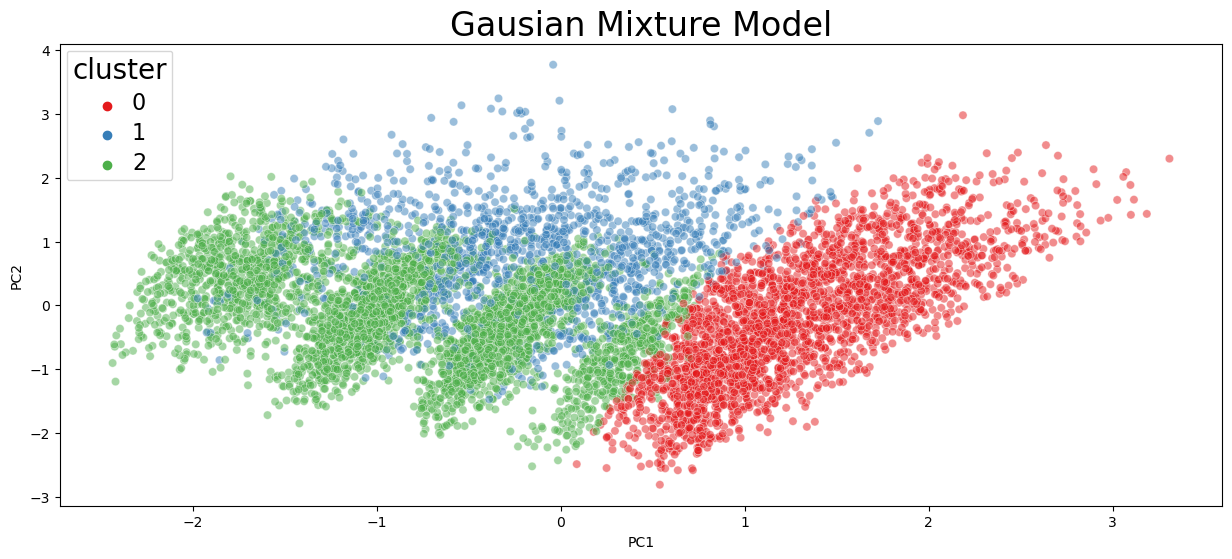

In [73]:
cluster_GMM_random, score_GMM_random = GausianMixtureModel_plot_givenMethod(df_pca, df_plot=df_pca, n_clusters=N_CLUSTERS, covariance_type='full', method='random', plot=True)


## Use clustering on data

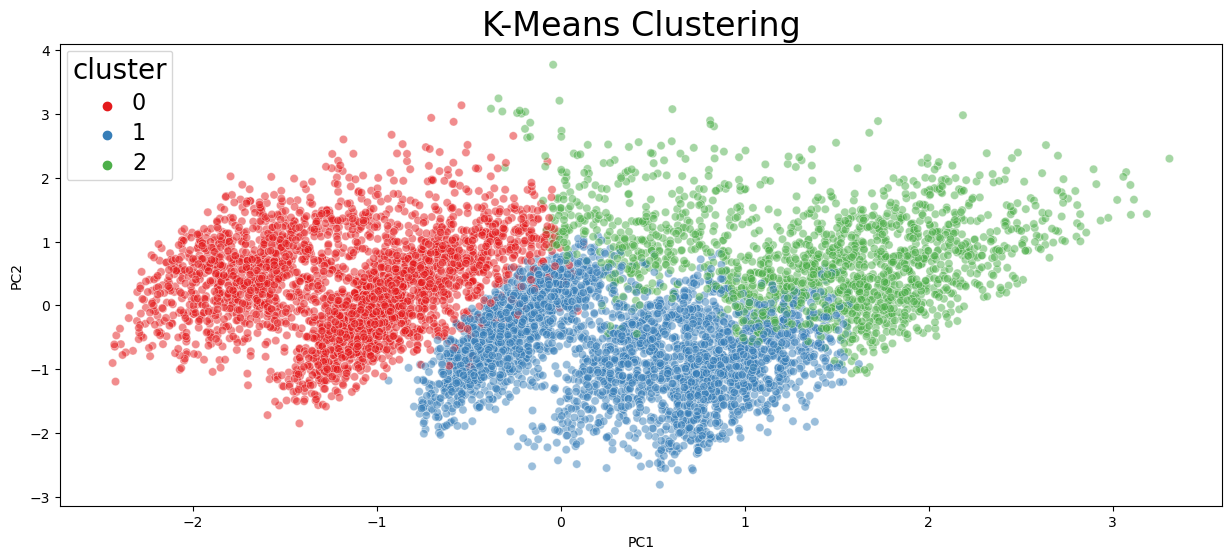

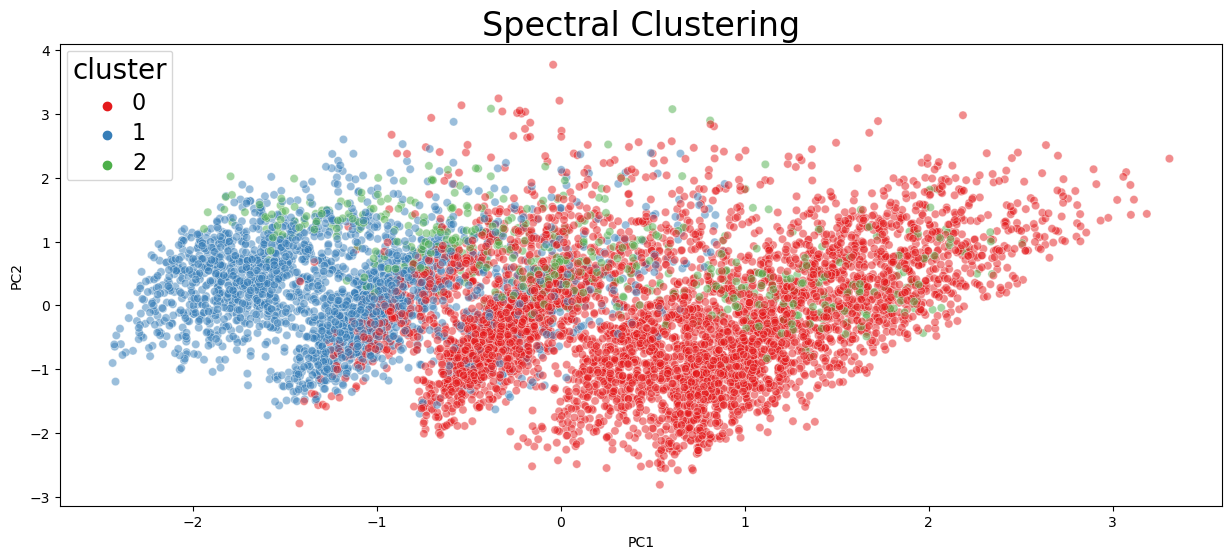

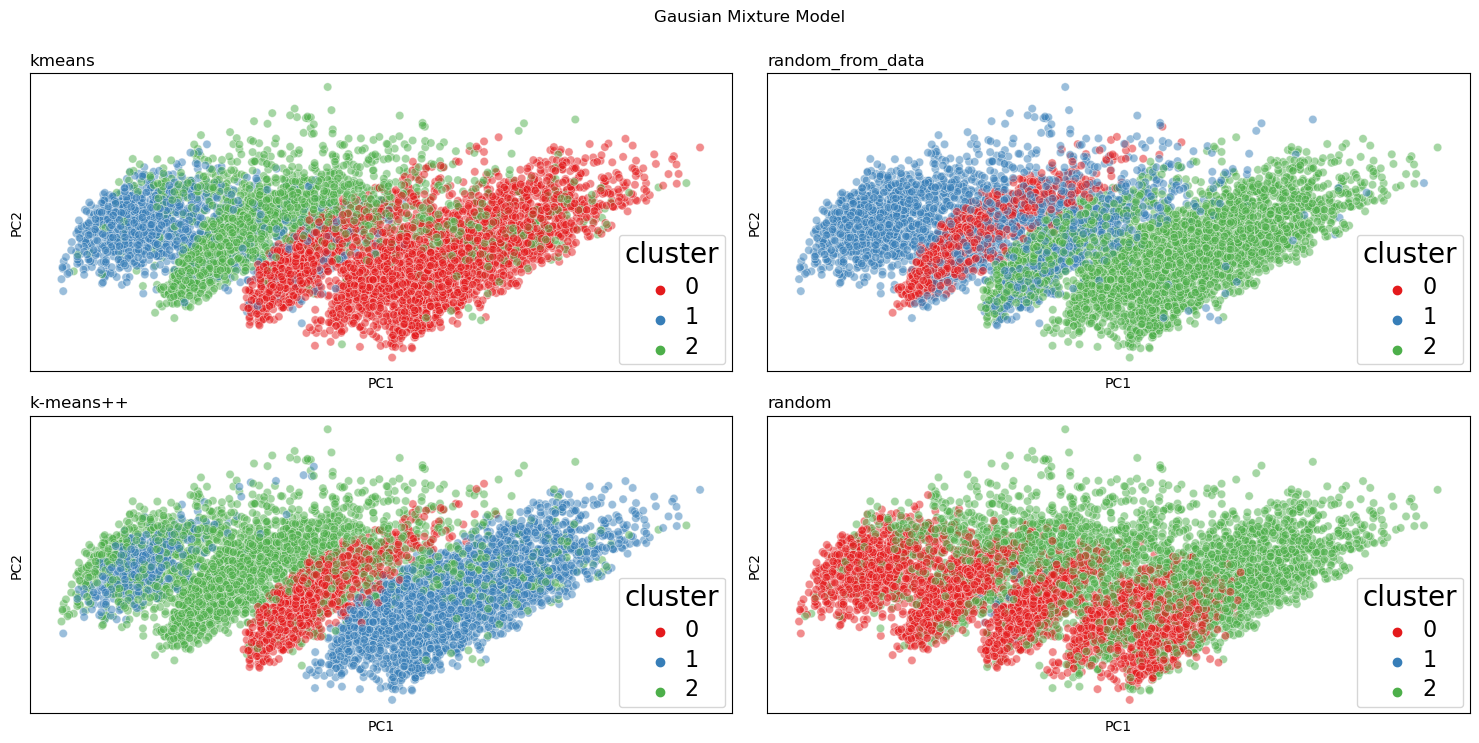

(0.14471698,
 0.123970374,
 [0.08681321, 0.038737044, 0.019350292, -0.0012074914],
 array([-1, -1, -1, ...,  0,  0, -1], dtype=int64))

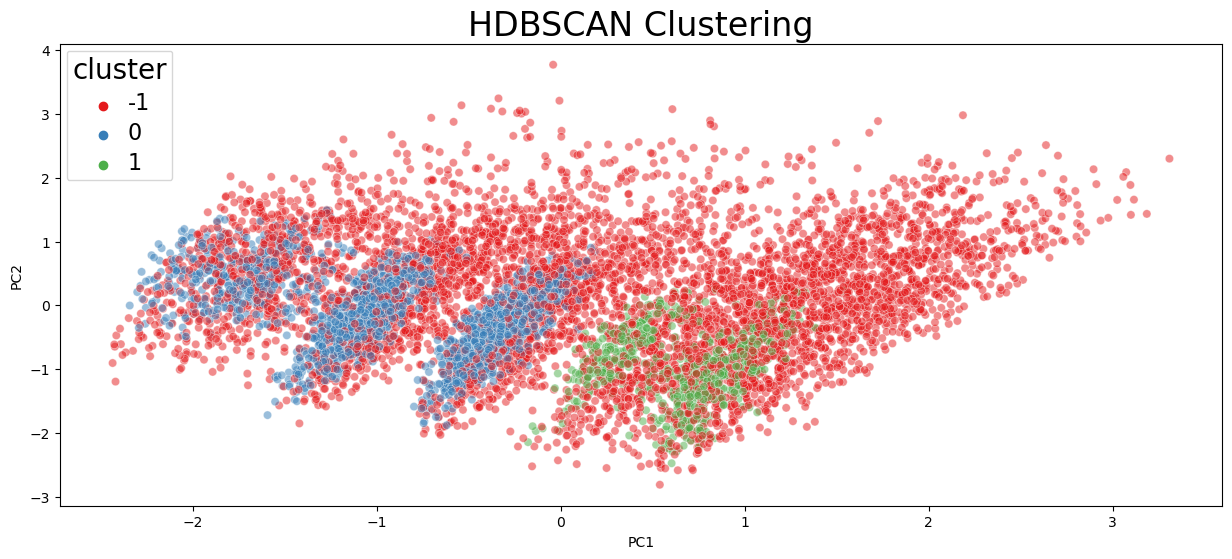

In [74]:
clusters_KMeans, score_KMeans = KMeans_plot(df_encoded, df_plot=df_pca, n_clusters=N_CLUSTERS, plot=True)
clusters_SC, score_SC = SpectralClustering_plot(df_encoded, df_plot=df_pca, n_clusters=N_CLUSTERS, plot=True)
clusters_GMM, score_GMM = GausianMixtureModel_plot(df_encoded, df_plot=df_pca, n_clusters=N_CLUSTERS, covariance_type='full', plot=True)
clusters_HDB, score_HDB_pca = HDBSCAN_plot(df_encoded, df_plot=df_pca, min_samples = 5, min_cluster_size = 500, plot=True, pc=[0,1])

score_KMeans, score_SC, score_GMM, clusters_HDB

# STraTS + PCA then clustering

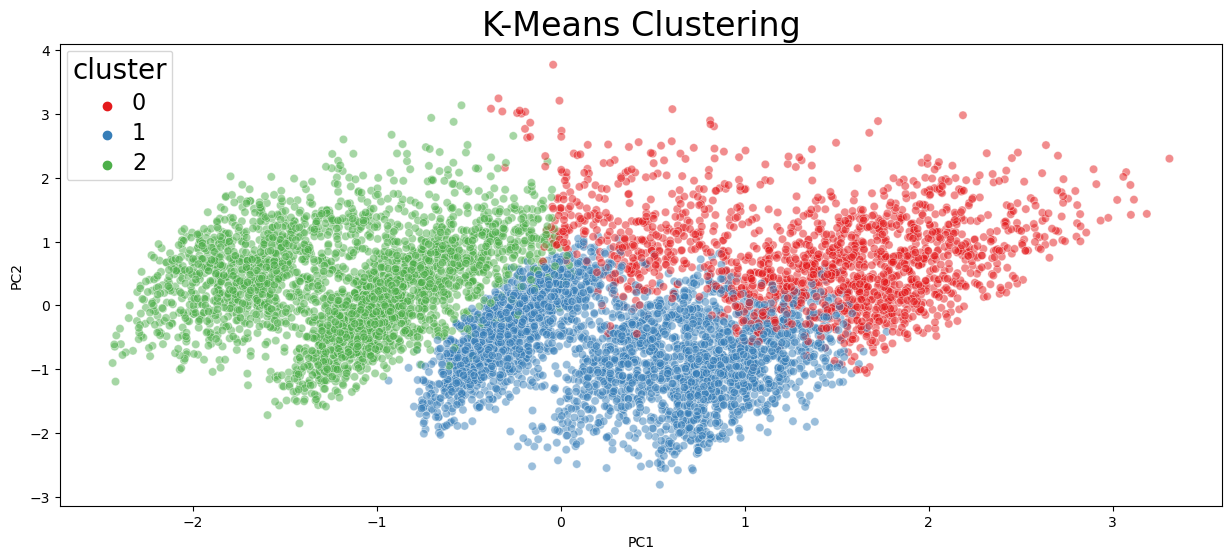

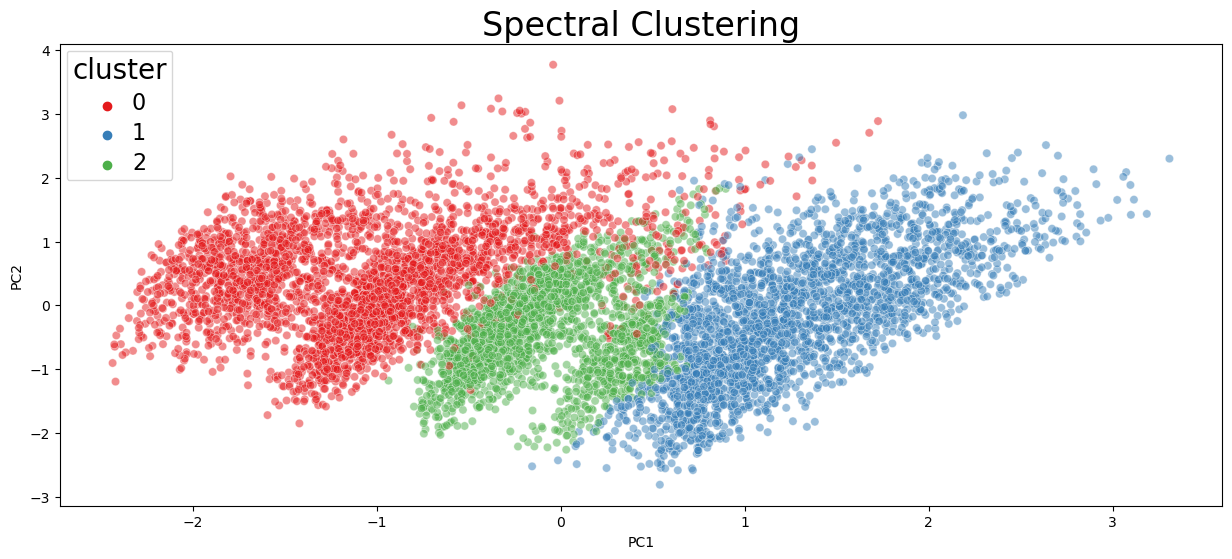

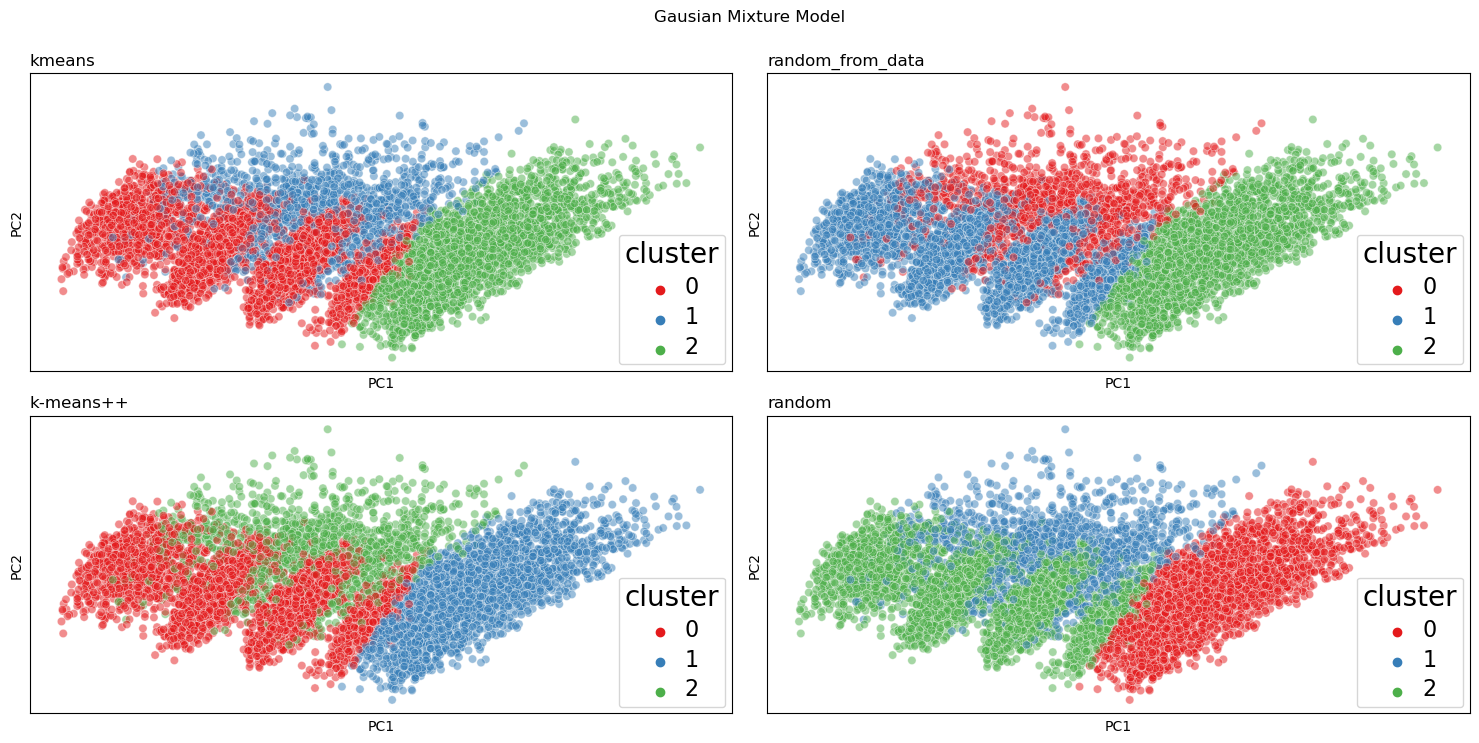

(0.30691984,
 0.18581668,
 [0.23159938, 0.23159938, 0.23159938, 0.23159938],
 array([0, 2, 0, ..., 0, 0, 0], dtype=int64))

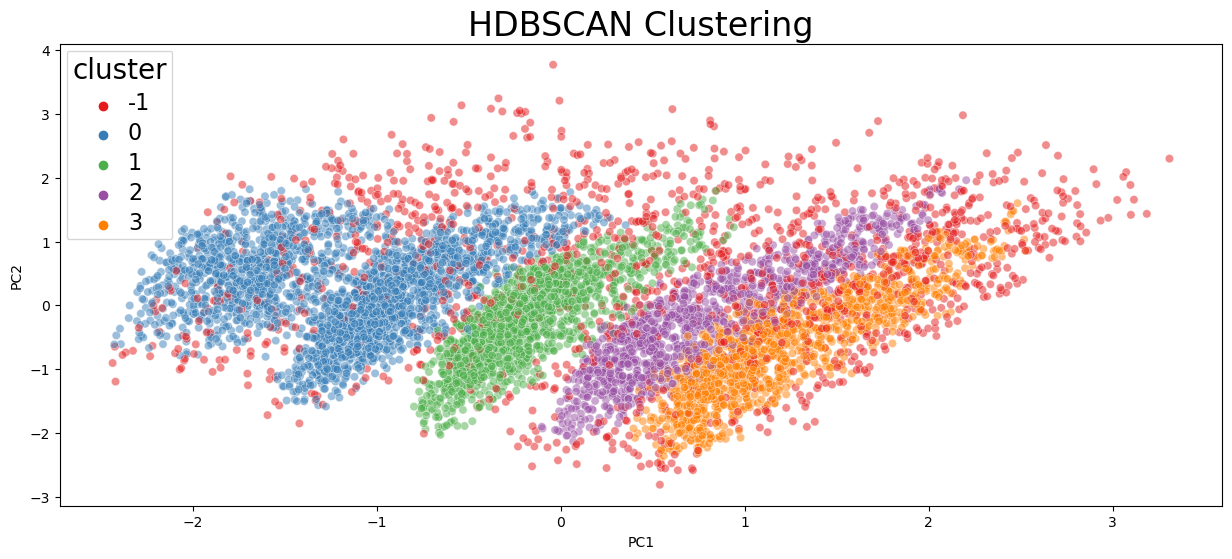

In [75]:
clusters_KMeans_pca, score_KMeans_pca = KMeans_plot(df_pca, n_clusters=N_CLUSTERS, plot=True)
clusters_SC_pca, score_SC_pca = SpectralClustering_plot(df_pca, n_clusters=N_CLUSTERS, plot=True)
clusters_GMM_pca, score_GMM_pca = GausianMixtureModel_plot(df_pca, n_clusters=N_CLUSTERS, covariance_type='full', plot=True)
clusters_HDB_pca, score_HDB_pca_pca = HDBSCAN_plot(df_pca, min_samples = 5, min_cluster_size = 500, plot=True, pc=[0,1])

score_KMeans_pca, score_SC_pca, score_GMM_pca, clusters_HDB_pca

### HDBSCAN Good clusters :)

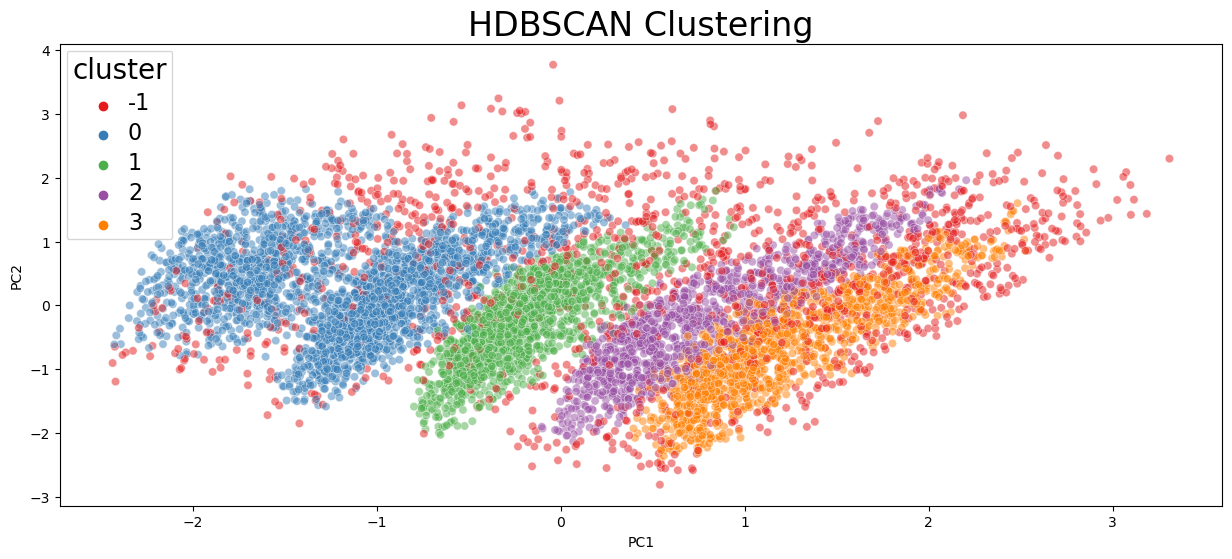

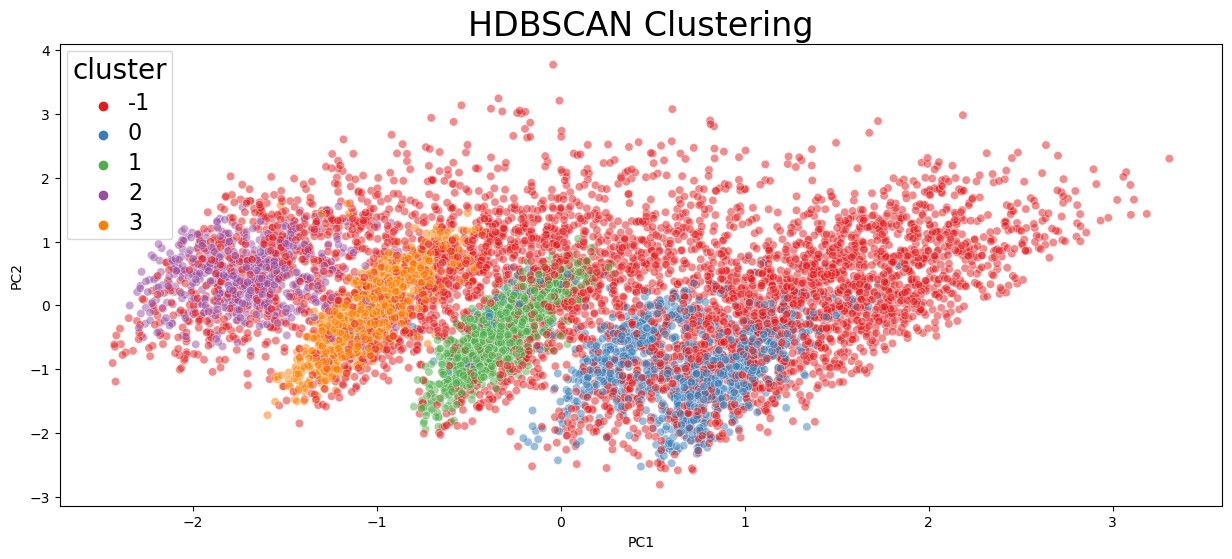

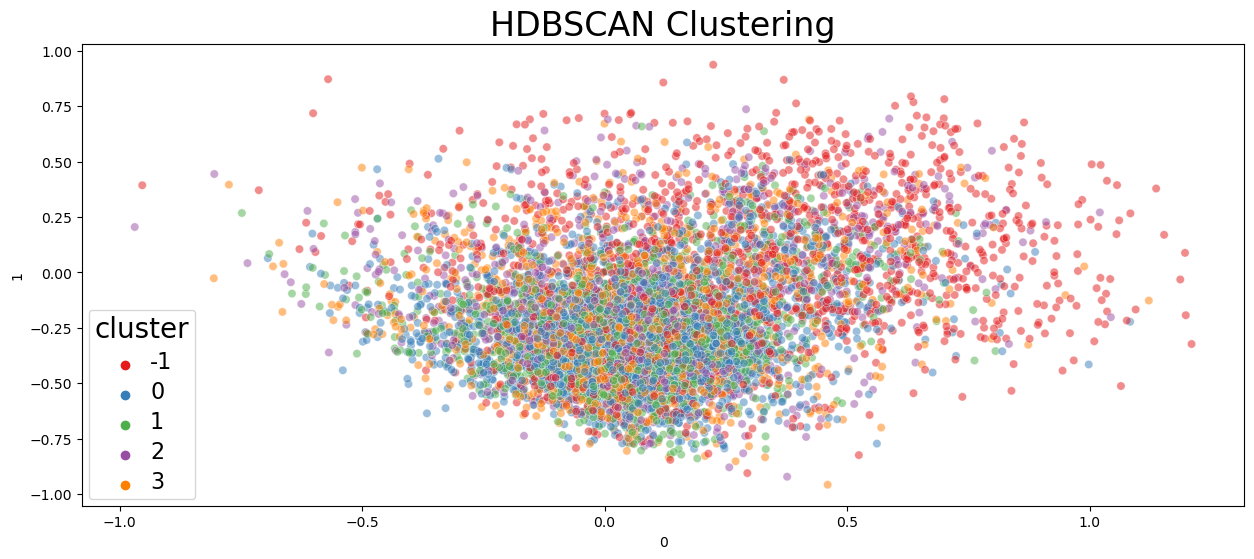

In [76]:
clusters_HDB_pca, score_HDB_pca = HDBSCAN_plot(df_pca, min_samples = 5, min_cluster_size = 500, plot=True, pc=[0,1])
clusters_HDB_enc, score_HDB_enc = HDBSCAN_plot(df_encoded, df_plot=df_pca, min_samples = 1, min_cluster_size = 500, plot=True)
_, _ = HDBSCAN_plot(df_pca, df_plot=df_encoded, min_samples = 5, min_cluster_size = 500, plot=True)



## Compare to classical methods PCA

C:\Users\burma\AppData\Local\Temp\ipykernel_26968\2092131184.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_orig_group_mean = df_orig.groupby(by='PatientID').mean()


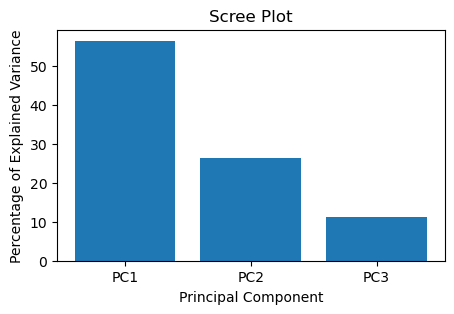

Scores for original data with PCA
	KMeans
min: 0.2379, max: 0.3035, mean: 0.2862
	Spectral Clustering
min: 0.2436, max: 0.2663, mean: 0.1677
	Gaussian Mixture Model
min: 0.1359, max: 0.2496, mean: 0.1564 with: kmeans, kmeans, kmeans.
	HDBSCAN
min: -42.0000, max: -42.0000, mean: -42.0000


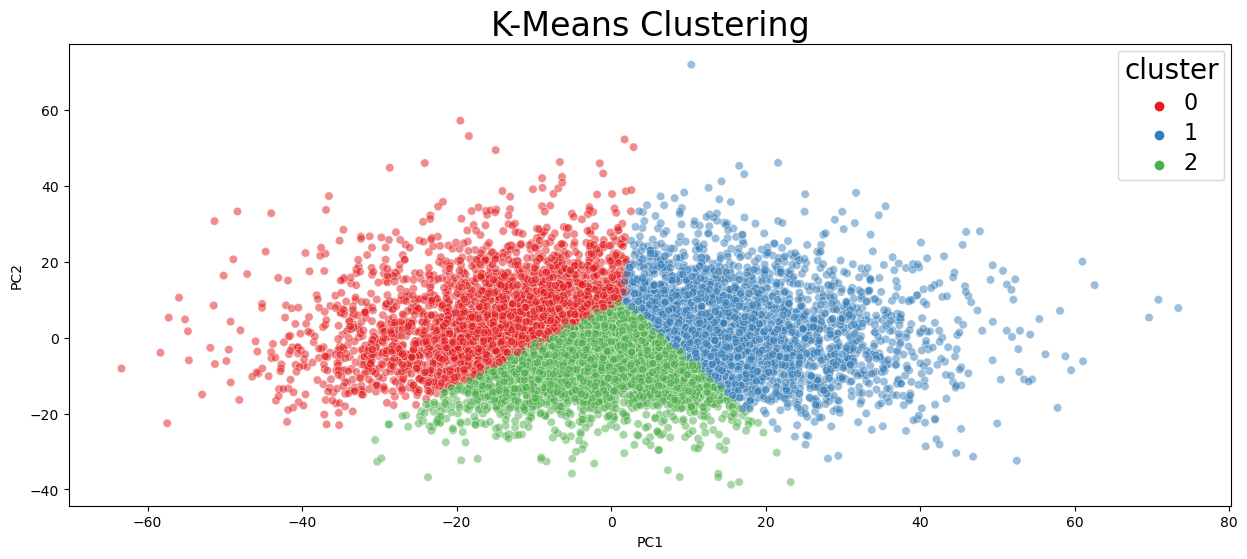

In [77]:
# Naive approach, min, max, mean values for each patients variable.
df_orig_group_min = df_orig.groupby(by='PatientID').min()
df_orig_group_max = df_orig.groupby(by='PatientID').max()
df_orig_group_mean = df_orig.groupby(by='PatientID').mean()

# Find PCA from variables:
# 'WardID', 'Systolic', 'Diastolic', 'O2', 'Pulse', 'Temp', 'Rf', 'onO2', 'Unconscious'
# Normalized with optimal value for each variabel. 
df_orig_group_min_pca = PCA_df(df_orig_group_min.drop(['Timestamp'],axis=1), n_components=DIM_REDUCTION_TO, plot=True)
df_orig_group_max_pca = PCA_df(df_orig_group_max.drop(['Timestamp'],axis=1), n_components=DIM_REDUCTION_TO, plot=False)
df_orig_group_mean_pca = PCA_df(df_orig_group_mean.drop(['Timestamp'],axis=1), n_components=DIM_REDUCTION_TO, plot=False)

print(f"Scores for original data with PCA")
# Cluster with K-means
clusters_orig_min_pca, score_orig_min_pca   = KMeans_plot(df_orig_group_min_pca,  n_clusters=N_CLUSTERS, plot=True)
clusters_orig_max_pca, score_orig_max_pca   = KMeans_plot(df_orig_group_max_pca,  n_clusters=N_CLUSTERS, plot=False)
clusters_orig_mean_pca, score_orig_mean_pca = KMeans_plot(df_orig_group_mean_pca, n_clusters=N_CLUSTERS, plot=False)
print(f"\tKMeans")
print(f"min: {score_orig_min_pca:.4f}, max: {score_orig_max_pca:.4f}, mean: {score_orig_mean_pca:.4f}")



# Spectral Clustering
clusters_SC_pca_orig_group_min, score_SC_pca_orig_min = SpectralClustering_plot(df_orig_group_min_pca, n_clusters=N_CLUSTERS, plot=False)
clusters_SC_pca_orig_group_max, score_SC_pca_orig_max = SpectralClustering_plot(df_orig_group_max_pca, n_clusters=N_CLUSTERS, plot=False)
clusters_SC_pca_orig_group_mean, score_SC_pca_orig_mean = SpectralClustering_plot(df_orig_group_mean_pca, n_clusters=N_CLUSTERS, plot=False)
print(f"\tSpectral Clustering")
print(f"min: {score_SC_pca_orig_min:.4f}, max: {score_SC_pca_orig_max:.4f}, mean: {score_SC_pca_orig_mean:.4f}")


# Gaussian Mixture Model
GMMmethods = ["kmeans", "random_from_data", "k-means++", "random"]
clusters_GMM_pca_orig_group_min, score_GMM_pca_orig_min = GausianMixtureModel_plot(df_orig_group_min_pca, n_clusters=N_CLUSTERS, covariance_type='full', plot=False)
clusters_GMM_pca_orig_group_max, score_GMM_pca_orig_max = GausianMixtureModel_plot(df_orig_group_max_pca, n_clusters=N_CLUSTERS, covariance_type='full', plot=False)
clusters_GMM_pca_orig_group_mean, score_GMM_pca_orig_mean = GausianMixtureModel_plot(df_orig_group_mean_pca, n_clusters=N_CLUSTERS, covariance_type='full', plot=False)
print(f"\tGaussian Mixture Model")
print(f"min: {np.max(score_GMM_pca_orig_min):.4f}, max: {np.max(score_GMM_pca_orig_max):.4f}, mean: {np.max(score_GMM_pca_orig_mean):.4f} with: {GMMmethods[np.argmax([score_GMM_pca_orig_min])]}, {GMMmethods[np.argmax([score_GMM_pca_orig_max])]}, {GMMmethods[np.argmax([score_GMM_pca_orig_mean])]}.")


# HDBSCAN
clusters_HDB_pca_orig_group_min, score_HDB_pca_orig_min = HDBSCAN_plot(df_orig_group_min_pca, min_samples = 5, min_cluster_size = 500, plot=False, pc=[0,1])
clusters_HDB_pca_orig_group_max, score_HDB_pca_orig_max = HDBSCAN_plot(df_orig_group_max_pca, min_samples = 5, min_cluster_size = 500, plot=False, pc=[0,1])
clusters_HDB_pca_orig_group_mean, score_HDB_pca_orig_mean = HDBSCAN_plot(df_orig_group_mean_pca, min_samples = 5, min_cluster_size = 500, plot=False, pc=[0,1])
print(f"\tHDBSCAN")
print(f"min: {score_HDB_pca_orig_min:.4f}, max: {score_HDB_pca_orig_max:.4f}, mean: {score_HDB_pca_orig_mean:.4f}")

### T-Sne

In [78]:
from sklearn.manifold import TSNE


if USE_TSNE:
    # Find T-Sne from variables:
    # 'WardID', 'Systolic', 'Diastolic', 'O2', 'Pulse', 'Temp', 'Rf', 'onO2', 'Unconscious'
    tsne = TSNE(random_state=42, learning_rate='auto', n_components=DIM_REDUCTION_TO, n_iter=1000, init='pca', perplexity=100.0)
    df_orig_group_min_tsne =  pd.DataFrame(tsne.fit_transform(df_orig_group_min.drop(['Timestamp'],axis=1)))
    df_orig_group_max_tsne =  pd.DataFrame(tsne.fit_transform(df_orig_group_max.drop(['Timestamp'],axis=1)))
    df_orig_group_mean_tsne =  pd.DataFrame(tsne.fit_transform(df_orig_group_mean.drop(['Timestamp'],axis=1)))

    print(f"Scores for original data with T-SNE")
    # Cluster with K-means
    clusters_orig_min_TSne, score_orig_min_TSne   = KMeans_plot(df_orig_group_min_tsne,  n_clusters=N_CLUSTERS, plot=False)
    clusters_orig_max_TSne, score_orig_max_TSne   = KMeans_plot(df_orig_group_max_tsne,  n_clusters=N_CLUSTERS, plot=False)
    clusters_orig_mean_TSne, score_orig_mean_TSne = KMeans_plot(df_orig_group_mean_tsne, n_clusters=N_CLUSTERS, plot=False)
    
    print(f"\tKMeans")
    print(f"min: {score_orig_min_TSne:.4f}, max: {score_orig_max_TSne:.4f}, mean: {score_orig_mean_TSne:.4f}")

    # Spectral Clustering
    clusters_SC_TSne_orig_group_min, score_SC_TSne_orig_min = SpectralClustering_plot(df_orig_group_min_tsne, n_clusters=N_CLUSTERS, plot=False)
    clusters_SC_TSne_orig_group_max, score_SC_TSne_orig_max = SpectralClustering_plot(df_orig_group_max_tsne, n_clusters=N_CLUSTERS, plot=False)
    clusters_SC_TSne_orig_group_mean, score_SC_TSne_orig_mean = SpectralClustering_plot(df_orig_group_mean_tsne, n_clusters=N_CLUSTERS, plot=False)
    print(f"\tSpectral Clustering")
    print(f"min: {score_SC_TSne_orig_min:.4f}, max: {score_SC_TSne_orig_max:.4f}, mean: {score_SC_TSne_orig_mean:.4f}")

    # Gaussian Mixture Model
    GMMmethods = ["kmeans", "random_from_data", "k-means++", "random"]
    clusters_GMM_TSne_orig_group_min, score_GMM_TSne_orig_min = GausianMixtureModel_plot(df_orig_group_min_tsne, n_clusters=N_CLUSTERS, covariance_type='full', plot=False)
    clusters_GMM_TSne_orig_group_max, score_GMM_TSne_orig_max = GausianMixtureModel_plot(df_orig_group_max_tsne, n_clusters=N_CLUSTERS, covariance_type='full', plot=False)
    clusters_GMM_TSne_orig_group_mean, score_GMM_TSne_orig_mean = GausianMixtureModel_plot(df_orig_group_mean_tsne, n_clusters=N_CLUSTERS, covariance_type='full', plot=False)
    print(f"\tGaussian Mixture Model")
    print(f"min: {np.max(score_GMM_TSne_orig_min):.4f}, max: {np.max(score_GMM_TSne_orig_max):.4f}, mean: {np.max(score_GMM_TSne_orig_mean):.4f} with: {GMMmethods[np.argmax([score_GMM_TSne_orig_min])]}, {GMMmethods[np.argmax([score_GMM_TSne_orig_max])]}, {GMMmethods[np.argmax([score_GMM_TSne_orig_mean])]}.")

    # HDBSCAN
    clusters_HDB_TSne_orig_group_min, score_HDB_TSne_orig_min = HDBSCAN_plot(df_orig_group_min_tsne, min_samples = 5, min_cluster_size = 500, plot=False, pc=[0,1])
    clusters_HDB_TSne_orig_group_max, score_HDB_TSne_orig_max = HDBSCAN_plot(df_orig_group_max_tsne, min_samples = 5, min_cluster_size = 500, plot=False, pc=[0,1])
    clusters_HDB_TSne_orig_group_mean, score_HDB_TSne_orig_mean = HDBSCAN_plot(df_orig_group_mean_tsne, min_samples = 5, min_cluster_size = 500, plot=False, pc=[0,1])
    print(f"\tHDBSCAN")
    print(f"min: {score_HDB_TSne_orig_min:.4f}, max: {score_HDB_TSne_orig_max:.4f}, mean: {score_HDB_TSne_orig_mean:.4f}")

Scores for original data with T-SNE
	KMeans
min: 0.3264, max: 0.3528, mean: 0.3349
	Spectral Clustering
min: 0.3195, max: 0.1723, mean: 0.3037


c:\Users\burma\anaconda3\envs\strats_TF2_11\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


	Gaussian Mixture Model
min: 0.2985, max: 0.2755, mean: 0.1678 with: k-means++, kmeans, k-means++.
	HDBSCAN
min: -0.0210, max: -0.0156, mean: 0.0345


In [98]:
if USE_TSNE:
    # Find T-Sne from variables:
    # 'WardID', 'Systolic', 'Diastolic', 'O2', 'Pulse', 'Temp', 'Rf', 'onO2', 'Unconscious'
    tsne = TSNE(random_state=42, learning_rate='auto', n_components=DIM_REDUCTION_TO, n_iter=1000, init='pca', perplexity=100.0)
    df_orig_group_min_tsne =  pd.DataFrame(tsne.fit_transform(df_orig_group_min.drop(['Timestamp'],axis=1)))
    df_orig_group_max_tsne =  pd.DataFrame(tsne.fit_transform(df_orig_group_max.drop(['Timestamp'],axis=1)))
    df_orig_group_mean_tsne =  pd.DataFrame(tsne.fit_transform(df_orig_group_mean.drop(['Timestamp'],axis=1)))

    print(f"Scores for original data with T-SNE")
    # Cluster with K-means
    clusters_orig_min_TSne, score_orig_min_TSne   = KMeans_plot(df_orig_group_min_tsne,  n_clusters=N_CLUSTERS, plot=False)
    clusters_orig_max_TSne, score_orig_max_TSne   = KMeans_plot(df_orig_group_max_tsne,  n_clusters=N_CLUSTERS, plot=False)
    clusters_orig_mean_TSne, score_orig_mean_TSne = KMeans_plot(df_orig_group_mean_tsne, n_clusters=N_CLUSTERS, plot=False)
    
    print(f"\tKMeans")
    print(f"min: {score_orig_min_TSne:.4f}, max: {score_orig_max_TSne:.4f}, mean: {score_orig_mean_TSne:.4f}")

Scores for original data with T-SNE
	KMeans
min: 0.3265, max: 0.3528, mean: 0.3349


## Print scores

In [79]:
GMMmethods = ["kmeans", "random_from_data", "k-means++", "random"]

print('Score on Encoded data')
print(f'{np.round(score_KMeans, 3)} Silhouette score from KMeans')
print(f'{np.round(score_SC, 3)} Silhouette score from Spectral Clustering')
print(f'{np.round(score_GMM, 3)} Silhouette score from GMM.')
print(f'{np.round(np.max(score_GMM), 3)} Silhouette score from GMM with {GMMmethods[np.argmax([score_GMM])]} method.')
print(f'{np.round(score_HDB_enc, 3)} Silhouette score from HDBSCAN')

print(f'\nScore on Encoded data + PCA')
print(f'{np.round(score_KMeans_pca, 3)} Silhouette score from KMeans')
print(f'{np.round(score_SC_pca, 3)} Silhouette score from Spectral Clustering')
print(f'{np.round(score_GMM_pca, 3)} Silhouette score from GMM.')
print(f'{np.round(np.max(score_GMM_pca), 3)} Silhouette score from GMM with {GMMmethods[np.argmax([score_GMM_pca])]} method.')
print(f'{np.round(score_HDB_pca, 3)} Silhouette score from HDBSCAN')

amax = ['min', 'max', 'mean']

print(f'\nScore on original data')
print(f'{np.round(np.max([score_orig_min_pca, score_orig_max_pca, score_orig_mean_pca]), 3)} Silhouette score from on KMeans on PCA from <{amax[np.argmax([score_orig_min_pca, score_orig_max_pca, score_orig_mean_pca])]}> data.')
if USE_TSNE: print(f'{np.round(np.max([score_orig_min_TSne, score_orig_max_TSne, score_orig_mean_TSne]), 3)} Silhouette score from on KMeans on T-SNE from <{amax[np.argmax([score_orig_min_TSne, score_orig_max_TSne, score_orig_mean_TSne])]}> data.')




Score on Encoded data
0.14499999582767487 Silhouette score from KMeans
0.12399999797344208 Silhouette score from Spectral Clustering
[ 0.087  0.039  0.019 -0.001] Silhouette score from GMM.
0.08699999749660492 Silhouette score from GMM with kmeans method.
-0.05000000074505806 Silhouette score from HDBSCAN

Score on Encoded data + PCA
0.3070000112056732 Silhouette score from KMeans
0.1860000044107437 Silhouette score from Spectral Clustering
[0.232 0.232 0.232 0.232] Silhouette score from GMM.
0.23199999332427979 Silhouette score from GMM with kmeans method.
0.11699999868869781 Silhouette score from HDBSCAN

Score on original data
0.303 Silhouette score from on KMeans on PCA from <max> data.
0.3529999852180481 Silhouette score from on KMeans on T-SNE from <max> data.


### Get scores naive approach 


In [80]:
# PCA
PCA_score_KMeans, PCA_score_SC, PCA_score_GMM, PCA_score_HDB_enc = [],  [],  [],  []
for data in [df_orig_group_min_pca, df_orig_group_max_pca, df_orig_group_mean_pca]:
    _, pca_score_KMeans = KMeans_plot(data, n_clusters=N_CLUSTERS, plot=False)
    _, pca_score_SC = SpectralClustering_plot(data, n_clusters=N_CLUSTERS, plot=False)
    _, pca_score_GMM = GausianMixtureModel_plot(data, n_clusters=N_CLUSTERS, covariance_type='full', plot=False)
    _, pca_score_HDB_enc = HDBSCAN_plot(data, min_samples = 5, min_cluster_size = 50, plot=False)

    PCA_score_KMeans.append(pca_score_KMeans)
    PCA_score_SC.append(pca_score_SC)
    PCA_score_GMM.append(pca_score_GMM)
    PCA_score_HDB_enc.append(pca_score_HDB_enc)

print('Results from Naive approach with PCA in Silhouette score. Results in order [min, max, mean]')

print(PCA_score_KMeans, 'Silhouette score from K-means')
print(PCA_score_SC, 'Silhouette score from Spectral Clustering')
print(f'{PCA_score_GMM}, Silhouette scorefrom GMM.')
print(PCA_score_HDB_enc, 'Silhouette score from HDBSCAN')


Results from Naive approach with PCA in Silhouette score. Results in order [min, max, mean]
[0.2752238130597232, 0.3035558122026168, 0.25631809493743807] Silhouette score from K-means
[0.2439230339065993, 0.2661956043488046, 0.16769105817222862] Silhouette score from Spectral Clustering
[[0.13587493662479658, 0.13529861442139612, 0.1353163239610122, 0.13587493662479658], [0.2496351149657832, 0.2496351149657832, 0.2496351149657832, 0.2496351149657832], [0.156422329748013, 0.11804316621670649, 0.11804316621670649, 0.11812715660861424]], Silhouette scorefrom GMM.
[-0.15045573081190824, -0.22044912199647726, -0.23913185103639464] Silhouette score from HDBSCAN


In [81]:
# T-SNE: 
if USE_TSNE:
    TSNE_score_KMeans, TSNE_score_SC, TSNE_score_GMM, TSNE_score_HDB_enc = [],  [],  [],  []
    for data in [df_orig_group_min_tsne, df_orig_group_max_tsne, df_orig_group_mean_tsne]:
        _, tsne_score_KMeans = KMeans_plot(data, n_clusters=N_CLUSTERS, plot=False)
        _, tsne_score_SC = SpectralClustering_plot(data, n_clusters=N_CLUSTERS, plot=False)
        _, tsne_score_GMM = GausianMixtureModel_plot(data, n_clusters=N_CLUSTERS, covariance_type='full', plot=False)
        _, tsne_score_HDB_enc = HDBSCAN_plot(data, min_samples = 5, min_cluster_size = 50, plot=False)

        TSNE_score_KMeans.append(tsne_score_KMeans)
        TSNE_score_SC.append(tsne_score_SC)
        TSNE_score_GMM.append(tsne_score_GMM)
        TSNE_score_HDB_enc.append(tsne_score_HDB_enc)

    print('Results from Naive approach with T-SNE in Silhouette score. Results in order [min, max, mean]')
    print(TSNE_score_KMeans, 'Silhouette score from K-means')
    print(TSNE_score_SC, 'Silhouette score from Spectral Clustering')
    print(f'{TSNE_score_GMM}, Silhouette scorefrom GMM. methods = ["kmeans", "random_from_data", "k-means++", "random"]. ')
    print(TSNE_score_HDB_enc, 'Silhouette score from HDBSCAN')

c:\Users\burma\anaconda3\envs\strats_TF2_11\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Results from Naive approach with T-SNE in Silhouette score. Results in order [min, max, mean]
[0.34377527, 0.35279575, 0.33492112] Silhouette score from K-means
[0.31945542, 0.1723149, 0.30365947] Silhouette score from Spectral Clustering
[[0.2984258, 0.29849932, 0.29851902, 0.20656173], [0.27553833, 0.08820977, 0.24375899, 0.27553833], [0.1678219, 0.1678219, 0.16783085, 0.16783085]], Silhouette scorefrom GMM. methods = ["kmeans", "random_from_data", "k-means++", "random"]. 
[-0.13740541, -0.12842268, -0.20890534] Silhouette score from HDBSCAN


In [82]:
K = range(2, 11)
fits = []
KNN_score = []
labels = []
uniques = []
for k in tqdm(K):
    # train the model for current value of k on training data
    model = KMeans(n_clusters = k, random_state = 0, n_init='auto').fit(df_encoded)
    kmeans_labels_str = [str(label) for label in model.labels_]
    
    # Append to lists
    fits.append(model)
    labels.append(kmeans_labels_str)
    uniques.append(np.unique(kmeans_labels_str, return_counts=True))
    KNN_score.append(silhouette_score(df_encoded, model.labels_, metric='euclidean'))
print(f"Score from KNN with K=2-->10:\n{KNN_score}")

100%|██████████| 9/9 [00:05<00:00,  1.58it/s]

Score from KNN with K=2-->10:
[0.17566776, 0.14471698, 0.119875684, 0.1278556, 0.10867704, 0.10731489, 0.10566659, 0.10694977, 0.10553076]


In [83]:
# print(f'Silhouette score for each amount of K-means: {score}')

# best_index = np.argmax(score)
# print(f'Best results with {len(uniques[best_index][1])} classes.')
# print('best index:', best_index)
# print('best score:',score[best_index])
# print('best uniques:',uniques[best_index])



In [84]:
df_orig

PatientID      Timestamp  WardID  Systolic  Diastolic   O2  Pulse  \
52991     279660  1657193109000       8      35.0      -26.0  1.0   15.0   
53084     279660  1657219712000       8      27.0       -5.0 -3.0   23.0   
52601     279660  1657248381000       8       8.0      -14.0 -4.0    6.0   
52705     279660  1657271411000       8      49.0        9.0 -5.0   14.0   
52857     279660  1657310860000       2      19.0        3.0 -3.0   17.0   
...          ...            ...     ...       ...        ...  ...    ...   
98546  311815932  1659661219000       3       0.0      -26.0  4.0   19.0   
98580  311815932  1659684480000       3     -10.0      -13.0  1.0   29.0   
98593  311815932  1659704700000       3     -17.0      -17.0  0.0   23.0   
98610  311815932  1659721631000       3     -12.0      -13.0  4.0   22.0   
98630  311815932  1659733303000       3     -10.0      -17.0 -2.0   35.0   

       Temp   Rf Gender  onO2  Unconscious  EwsScore  
52991  -0.1  6.0      0     0            0         2  
53084  -0.5  4.0      0     0            0         1  
52601  -0.4  2.0      0     1            0         2  
52705   0.0  6.0      0     0            0         2  
52857  -0.9  2.0      0     0            0         0  
...     ...  ...    ...   ...          ...       ...  
98546  -0.8  6.0      0     0            0         2  
98580   2.3  1.0      0     0            0         4  
98593   1.8  4.0      0     0            0         3  
98610   2.5 -2.0      0     0            0         4  
98630  -1.1  4.0      0     0            0         4  

[115677 rows x 13 columns]

In [85]:
# data_orig[data_orig['variable']== 'StaticImputed']
data_orig[data_orig['variable']== 'Systolic']
static_data.variable.unique()
# .drop_duplicates(subset=['PatientID', feature])[feature].reset_index()[feature]

array(['WardID', 'Gender', 'StaticImputed', 'WardChange'], dtype=object)

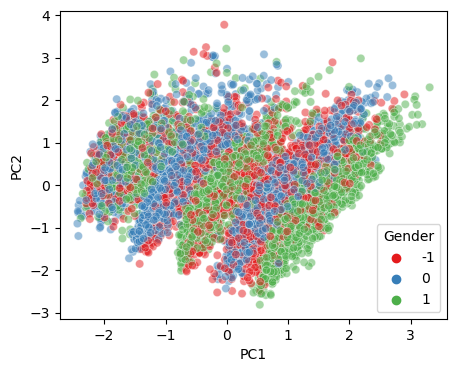

In [86]:
# Plot to check data
def plot_feature(df, df_orig, feature, palette='Set1', pc=[0,1]):
    df_plot=df.copy()
    
    try:
        df_plot[feature] = df_orig.drop_duplicates(subset=['PatientID', feature])[feature].reset_index()[feature]
    except:
        df_plot[feature] = df_orig.drop_duplicates(subset=['PatientID', 'variable'])[df_orig.drop_duplicates(subset=['PatientID', 'variable']).variable == feature].reset_index().value
    plt.figure(figsize=(5, 4))
    sns.scatterplot(data = df_plot, x=df_plot.columns[pc[0]], y=df_plot.columns[pc[1]], hue=feature, alpha=0.5, palette=palette)
    # plt.title(f"Encoded with PCA, color map {feature}.", fontsize=16)
    df_plot


plot_feature(df_pca, df_orig, 'Gender', pc=[0,1])
# plot_feature(df_pca, df_orig, 'WardID')
# plot_feature(df_pca, df_orig, 'Unconscious')
# plot_feature(df_pca, df_orig, 'Systolic', palette='flare')
# plot_feature(df_pca, df_orig, 'Diastolic', palette='flare')
# plot_feature(df_pca, df_orig, 'O2', palette='flare')
# plot_feature(df_pca, df_orig, 'Temp', palette='flare')
# plot_feature(df_pca, df_orig, 'Rf', palette='flare')
# plot_feature(df_pca, df_orig, 'onO2', palette='flare')
# plot_feature(df_pca, df_orig, 'EwsScore', palette='flare')
# # plot_feature(df_pca, df_orig, 'EwsType', palette='flare')
# plot_feature(df_pca, static_data, 'StaticImputed')
# plot_feature(df_pca, static_data, 'WardChange')